In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read QDM data

First, we create a read the observation points.

In [81]:
sample_name = "IRM_200G"

In [82]:
data_dir = pathlib.Path("..") / ".." / "data" / "loess"
data = mg.load_qdm(data_dir / str(sample_name+".mat"))

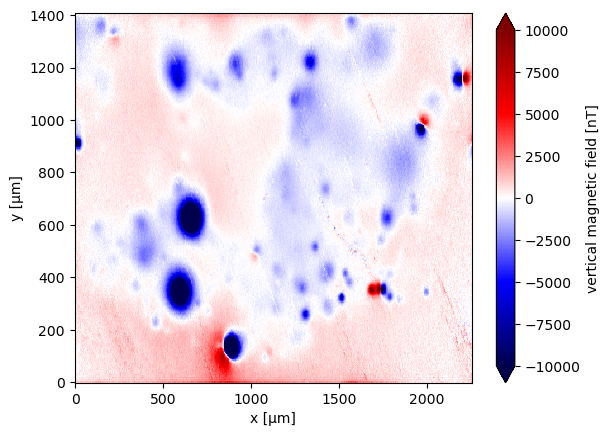

In [83]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional-Residual Separation

In [84]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [85]:
region = vd.get_region(coordinates)
block_spacing = 200#*mg.MICROMETER_TO_METER # meters
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.5)),
    drop_coords=False
)

coords_blocked, data_blocked = reducer.filter(coordinates, data=data.bz.values)
print(np.shape(coords_blocked))
print(np.shape(data_blocked))

(3, 96)
(96,)


/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7fbf70193a30> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7fbf70193a30> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


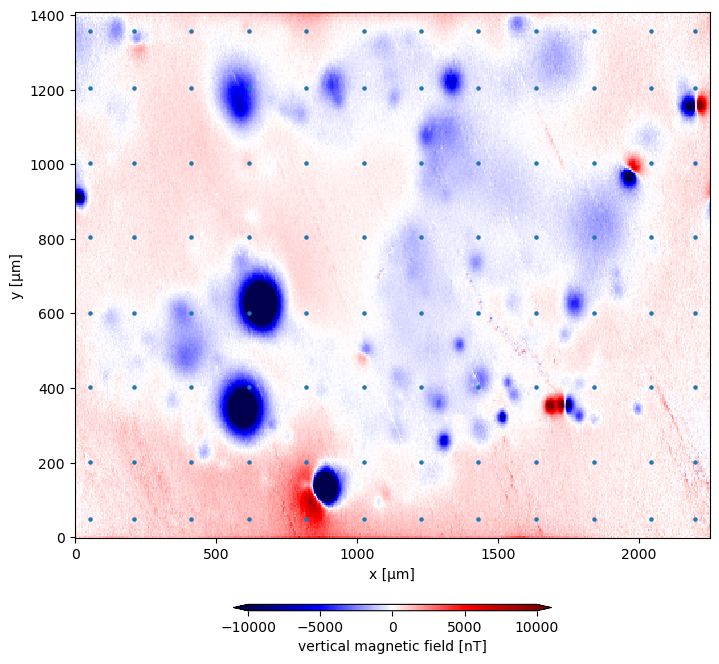

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.095, shrink=0.5)
scale=10000
tmp=data.bz.plot.pcolormesh(ax=ax, cmap='seismic', cbar_kwargs=cbar_kwargs, vmin=-scale, vmax=scale)

ax.scatter(*coords_blocked[:2], s=5)

ax.set_aspect("auto")

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

In [87]:
damping = 1e1
depth = 300*mg.MICROMETER_TO_METER
grid_spacing = 1*mg.MICROMETER_TO_METER

eqs = hm.EquivalentSourcesGB(
    depth=depth,
    damping=damping,
    block_size=grid_spacing,
    window_size=100*mg.MICROMETER_TO_METER,
    random_state=0,
)

In [88]:
%%time
eqs.fit(np.asarray(coords_blocked)*mg.MICROMETER_TO_METER, data_blocked)

CPU times: user 3.34 s, sys: 36 ms, total: 3.38 s
Wall time: 811 ms


/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7fbf70193a30> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7fbf70193a30> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


EquivalentSourcesGB(block_size=1e-06, damping=10.0, depth=0.0003,
                    random_state=0, window_size=9.999999999999999e-05)

In [89]:
%%time
regional_data = eqs.predict(np.asarray(coordinates)*mg.MICROMETER_TO_METER)
regional_data

CPU times: user 127 ms, sys: 1.74 ms, total: 129 ms
Wall time: 11.3 ms


array([[795.19063742, 801.54824251, 807.98809571, ..., 426.71366646,
        425.41132441, 424.11227358],
       [795.33046386, 801.70996647, 808.17292489, ..., 427.33766649,
        426.03431641, 424.7342464 ],
       [795.37234556, 801.77160381, 808.25549304, ..., 427.94359062,
        426.63970631, 425.33908739],
       ...,
       [531.84684323, 533.37502905, 534.90398144, ..., 616.49496054,
        614.00520137, 611.48878897],
       [527.95175115, 529.43547793, 530.91985776, ..., 613.98352738,
        611.52076075, 609.03116179],
       [524.1171908 , 525.55800785, 526.99937631, ..., 611.43314193,
        608.99828945, 606.5364168 ]])

In [90]:
data = data.assign(regional_data=(['y','x'],regional_data))
data.regional_data.attrs = {"long_name": "regional-data", "units": "nT"}
data

<xarray.Dataset> Size: 3MB
Dimensions:        (y: 300, x: 480)
Coordinates:
  * x              (x) float64 4kB 0.0 4.7 9.4 ... 2.242e+03 2.247e+03 2.251e+03
  * y              (y) float64 2kB 0.0 4.7 9.4 ... 1.396e+03 1.401e+03 1.405e+03
    z              (y, x) float64 1MB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz             (y, x) float64 1MB 1.052e+03 884.9 432.2 ... 1.478e+03 981.5
    regional_data  (y, x) float64 1MB 795.2 801.5 808.0 ... 611.4 609.0 606.5
Attributes:
    file_name:  ../../data/loess/IRM_200G.mat

In [91]:
error = data.bz.values - data.regional_data.values

data = data.assign(error=(['y','x'],error))
data.error.attrs = {"long_name": "regional_data", "units": "nT"}
data

<xarray.Dataset> Size: 5MB
Dimensions:        (y: 300, x: 480)
Coordinates:
  * x              (x) float64 4kB 0.0 4.7 9.4 ... 2.242e+03 2.247e+03 2.251e+03
  * y              (y) float64 2kB 0.0 4.7 9.4 ... 1.396e+03 1.401e+03 1.405e+03
    z              (y, x) float64 1MB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz             (y, x) float64 1MB 1.052e+03 884.9 432.2 ... 1.478e+03 981.5
    regional_data  (y, x) float64 1MB 795.2 801.5 808.0 ... 611.4 609.0 606.5
    error          (y, x) float64 1MB 256.7 83.32 -375.8 ... -339.7 868.5 374.9
Attributes:
    file_name:  ../../data/loess/IRM_200G.mat

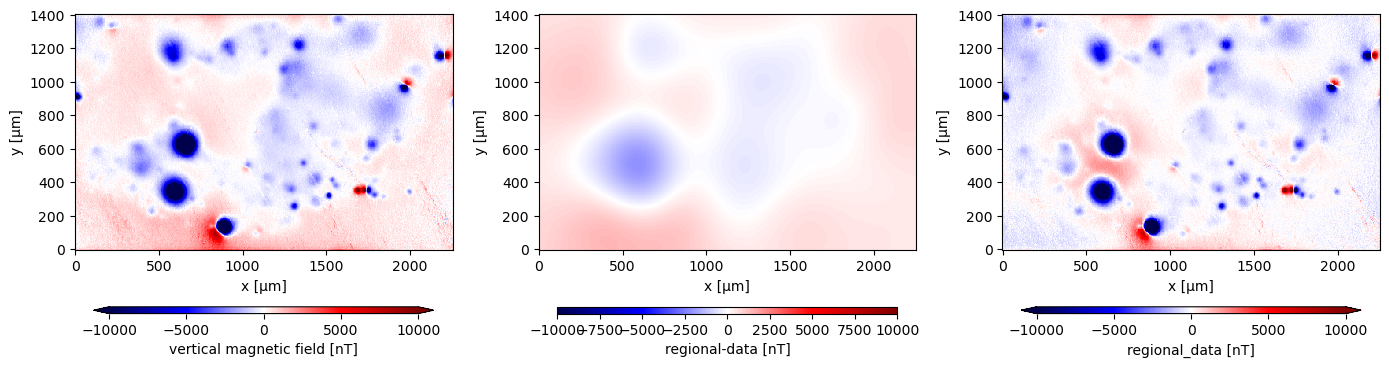

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "regional_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

In [93]:
data.bz.values = data.error.values

In [94]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

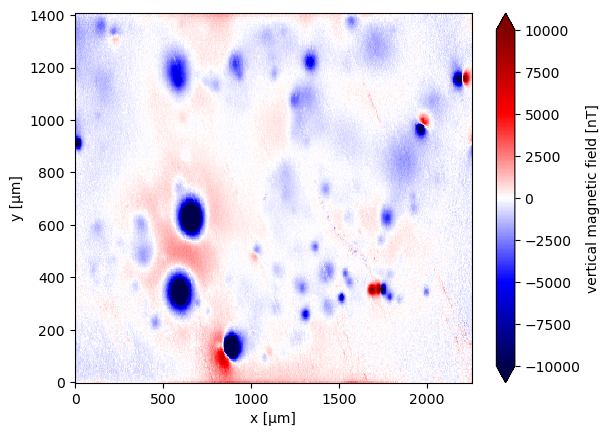

In [95]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [96]:
height_difference = 6

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 2MB
Dimensions:  (y: 300, x: 480)
Coordinates:
  * x        (x) float64 4kB 0.0 4.7 9.4 14.1 ... 2.242e+03 2.247e+03 2.251e+03
  * y        (y) float64 2kB 0.0 4.7 9.4 14.1 ... 1.396e+03 1.401e+03 1.405e+03
    z        (y, x) float64 1MB 11.0 11.0 11.0 11.0 11.0 ... 11.0 11.0 11.0 11.0
Data variables:
    bz       (y, x) float64 1MB -137.9 -278.3 -331.1 ... 8.761 53.91 -29.7

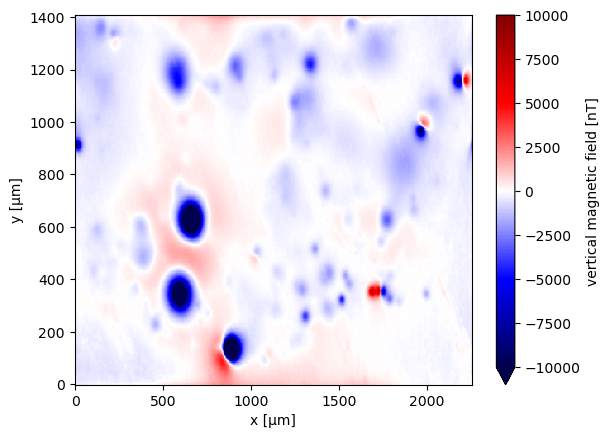

In [97]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [98]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 7MB
Dimensions:  (y: 300, x: 480)
Coordinates:
  * x        (x) float64 4kB 0.0 4.7 9.4 14.1 ... 2.242e+03 2.247e+03 2.251e+03
  * y        (y) float64 2kB 0.0 4.7 9.4 14.1 ... 1.396e+03 1.401e+03 1.405e+03
    z        (y, x) float64 1MB 11.0 11.0 11.0 11.0 11.0 ... 11.0 11.0 11.0 11.0
Data variables:
    bz       (y, x) float64 1MB -137.9 -278.3 -331.1 ... 8.761 53.91 -29.7
    tga      (y, x) float64 1MB 47.05 31.15 10.23 56.79 ... 9.473 65.96 56.67
    x_deriv  (y, x) float64 1MB -29.86 -20.55 -4.277 ... 3.36 -4.091 -17.79
    y_deriv  (y, x) float64 1MB -6.128 -3.997 -1.257 ... 7.948 14.03 20.46
    z_deriv  (y, x) float64 1MB -35.85 -23.06 -9.204 ... 3.908 -64.32 -49.77

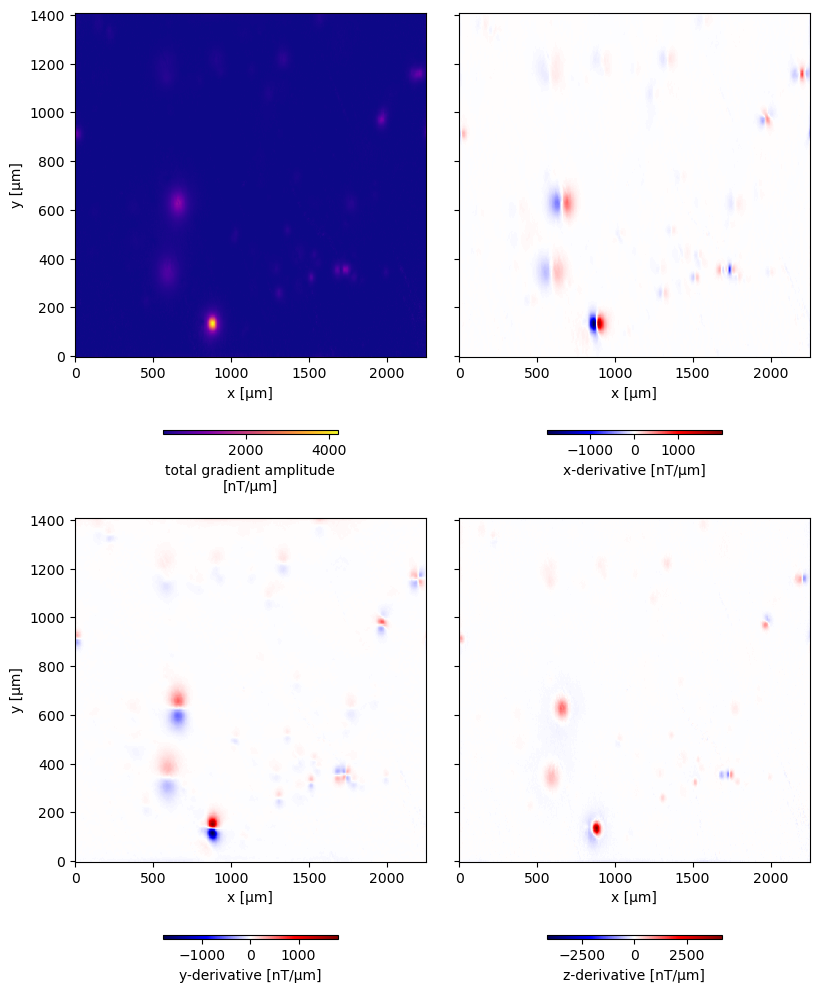

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [100]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)


data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

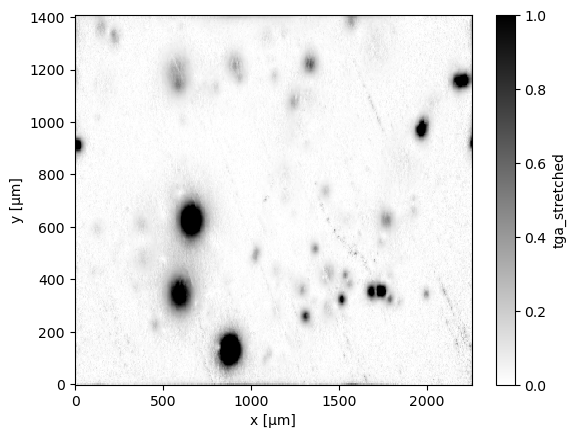

In [101]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Import windows

In [102]:
df_windows = pd.read_csv(data_dir/"windows.csv")
df_windows

index        x_min        x_max       y_min       y_max
0        0   685.947186   855.652814  483.847186  653.552814
1        1  1780.258875  1848.141125  351.458875  419.341125
2        2    64.758875   132.641125  760.358875  828.241125
3        3   643.647186   813.352814  192.447186  362.152814
4        4  1615.758875  1683.641125  309.158875  377.041125
..     ...          ...          ...         ...         ...
127    127   916.915224   953.684776  418.715224  455.484776
128    128  1307.015224  1343.784776  127.315224  164.084776
129    129  1349.315224  1386.084776  399.915224  436.684776
130    130  2044.915224  2081.684776  705.415224  742.184776
131    131  1015.615224  1052.384776  465.715224  502.484776

[132 rows x 5 columns]

In [103]:
windows = np.empty((len(df_windows),4))
windows[:, 0] = df_windows['x_min'].values
windows[:, 1] = df_windows['x_max'].values
windows[:, 2] = df_windows['y_min'].values
windows[:, 3] = df_windows['y_max'].values


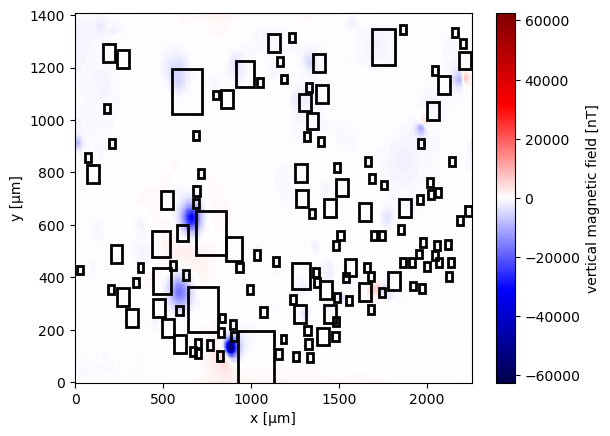

In [104]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [25]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler =  position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [26]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

112 euler positions and dipole moments estimated within 1.1543 seconds


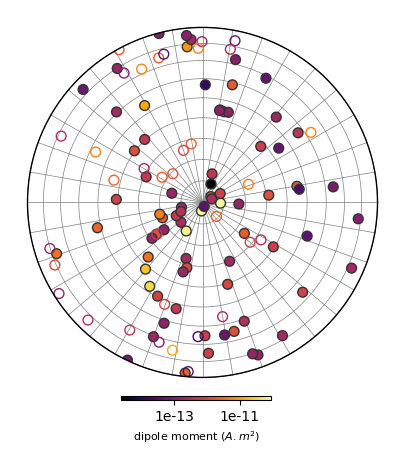

In [27]:
projection = mg.StereographicProjection(estimated_dipole_moments)

cmap = "inferno"
# Use matplotlib.colors.LogNorm for a log scale
cmap_norm = matplotlib.colors.LogNorm #Normalize

kwargs = dict(
   s=50, cmap=cmap, cmap_norm=cmap_norm
)  
# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(5,5))
tmp = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=8)
clb.ax.tick_params(labelsize=10)
plt.show()

# Iterative Euler deconvolution

In [28]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [29]:
# x_, y_ = np.meshgrid(data.x.values, data.y.values)
# coordinates = ([x_, y_ , data.z.values])

In [30]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows_filtered), total = len(np.array(windows_filtered))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])

    bounds = ((window[0]/position[0], window[1]/position[0]),  # bounds in x
              (window[2]/position[1], window[3]/position[1]),  # bounds in y
              (None, None),  # bounds in z
              (None, None), (None, None), (None, None))  # no bounds for moment
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args, bounds=bounds,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2

        # plot results
        show=False
        if show:
            ##############################################################################
            anomaly = anomaly.assign(predicted_data=(['y','x'],pred))
            anomaly.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}
            error = anomaly.data_minus_background.values - anomaly.predicted_data.values
            anomaly = anomaly.assign(error=(['y','x'],error))
            anomaly.error.attrs = {"long_name": "residual-data", "units": "nT"}
            
            fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
            axes = axes.ravel()
            ax = axes[0]
            tmp = anomaly.data_minus_background.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
            # fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
            ax.set_aspect("auto")
            ax = axes[1]
            tmp = anomaly.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
            # fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
            ax.set_aspect("auto")
            ax = axes[2]
            tmp = anomaly.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
            # fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
            ax.set_aspect("auto")
            plt.show()
            ##############################################################################
    
    estimated_dipole_moments_itr_euler.append(moment)
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)
    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [31]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 14.8862 seconds


In [32]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z           bz    z_deriv
0  686.2  484.1  11.0  -551.652178 -65.048022
1  690.9  484.1  11.0  -656.301928 -67.951202
2  695.6  484.1  11.0  -771.803200 -59.451385
3  700.3  484.1  11.0  -882.038434 -79.221239
4  705.0  484.1  11.0 -1027.796091 -80.691255

In [33]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

Output()

Output()

0.996529321308446 0.9971512973745011

0.9943608400799193 0.9981620451899793

0.9873762605776009 0.9941808918075986

0.9968804957223727 0.9971350346998737

0.9971350359461373 0.9971350346998737

0.9832650700649618 0.9861647413826521

0.8931578322261983 0.9859070860730715

0.9753729895442584 0.991218237428396

0.9772659611012657 0.9957185270689398

0.9203571502655202 0.935469791441713

0.9905658102845094 0.9915563042150484

0.9804539715138764 0.9962706290209722

0.9675053384064868 0.9915589545372416

0.9915590961898357 0.9915589545372416

0.7989417959810189 0.9552470678803675

0.9687440790595241 0.9968076238311847

0.9591653281170952 0.9972596702195797

0.9729648751499395 0.9866613204327707

0.931949210799595 0.988300850920281

0.8625171505254735 0.9649832821090214

0.9906893425591359 0.9959460371811352

0.9413099518200542 0.9941350299783219

0.9941351185772431 0.9941350299783219

0.9577543039225995 0.9913146434951793

0.96056625532343 0.9709950363261367

0.9709950382554942 0.9709950363261367

0.9350748075647545 0.9664178530184138

0.9664181108401455 0.9664178530184138

0.832091682654726 0.9626500114108113

0.9793652503320035 0.9916200890900502

0.9229201190712927 0.9623285325261786

0.9750856369524679 0.9923549042290405

0.9923549266619096 0.9923549042290405

0.9602352942579331 0.9909866279619441

0.5788555850861783 0.966175190456566

0.9812906809478695 0.9935271647788435

0.9935272282195056 0.9935271647788435

0.9151566634878582 0.9543306410310379

0.922392371882946 0.9983118776711861

0.998311887620858 0.9983118776711861

0.9808884720165137 0.9948348721114791

0.9960733330893492 0.9962891567492846

0.4589455095216104 0.9541503437238233

0.9541503792146283 0.9541503437238233

0.976306500600828 0.9916369058113232

0.9916371110534496 0.9916369058113232

0.9573705409010715 0.9824319435399073

0.9824325399465487 0.9824319435399073

0.9008657364614636 0.9773414492838326

0.9773416620599662 0.9773414492838326

0.910746139585717 0.9744962168462502

0.9744963550127201 0.9744962168462502

0.9453559851281806 0.9803128688775149

0.919199889003367 0.9932687520857936

0.9932693582210907 0.9932687520857936

0.9641325311554817 0.9974121999371569

0.9974122126208682 0.9974121999371569

0.7410212652918514 0.9893833196520483

0.6686793914652304 0.668688327689462

0.9803392548658975 0.668688327689462

0.923615260791008 0.992653908495393

0.8801704572798912 0.9566697407104241

0.6772991670375721 0.9406569146644187

0.9406569816859107 0.9406569146644187

0.5799950890450253 0.5799744415472086

0.9821019254886645 0.5799744415472086

0.7161260094910105 0.9421428068976455

0.9421572262598426 0.9421428068976455

0.8676808578809507 0.9920240168474576

0.8750510496983387 0.9170869098270484

0.9259416524372859 0.984570537411023

0.9845707297305006 0.984570537411023

0.8166489888768724 0.9913251338379164

0.9718828778571976 0.9962638289006273

0.8013309070033713 0.8855262754477861

0.885529034957047 0.8855262754477861

0.9277330556305523 0.976985814561853

0.7664353414253465 0.9851720536664342

0.985173710517607 0.9851720536664342

0.9846700444879303 0.9963176214639906

0.8435920686373927 0.9883019522393887

0.9446347912863494 0.9932814318560192

0.6693881414975805 0.9691397639341859

0.9853613422218781 0.9984333165004605

0.9984336305205969 0.9984333165004605

0.7837417162649124 0.9699686437904365

0.969980520322275 0.9699686437904365

0.6722714585349345 0.9895888573922095

0.9895980493276326 0.9895888573922095

0.9168576528129595 0.9707054082584117

0.9243345863371983 0.9478488184050042

0.947851387545313 0.9478488184050042

0.6280070414394842 0.9367650063254982

0.936778181816636 0.9367650063254982

0.9541019765306094 0.9950597202825733

0.6526546393385666 0.9783603679375382

0.9783603978714925 0.9783603679375382

0.8085515810562033 0.9525233481675003

0.9525251091527732 0.9525233481675003

0.7941785894991745 0.9349510814780089

0.9349511259338712 0.9349510814780089

0.8948803874796556 0.9698692726343815

0.9698760171423539 0.9698692726343815

0.5087190949645336 0.9385242749464436

0.8935657464342623 0.9965439549227559

0.9862403207739158 0.9606444281168851

0.9965438413404802 0.9606444281168851

0.8647225019089644 0.9763297519181575

0.3001430308401464 0.9764729395659163

0.8314281875942291 0.9866197446372087

0.7377142789945552 0.9891408951159685

0.7185464531803883 0.980893478507465

0.9866168366535054 0.980893478507465

0.8343076144986872 0.9777834247297474

0.9891407849339999 0.9777834247297474

0.81299478034381 0.9912379344754099

0.5716937156558317 0.9843457627504624

0.3131190178634169 0.9048739619564826

0.256192907142481 0.897261535386555

0.7024168359471635 0.9813212353057974

0.9437273105344718 0.9802286775793168

0.9912388061635765 0.9802286775793168

0.9028421068597918 0.9492518408561765

0.9843464077233466 0.9492518408561765

0.4660917395961074 0.9378563800698766

0.5435614835384845 0.8019364951114255

0.9050331336750231 0.8019364951114255

0.7709647237220277 0.9310435082454003

0.8167551121326837 0.15314483351763808

0.981314153099184 0.15314483351763808

0.833045984606478 0.8422279535731343

0.9802240553780561 0.8422279535731343

0.7768630522001808 0.9770351785531776

0.8213550773703022 0.9955425232862883

0.5472203656928862 -0.012298476626708688

0.8020423501483726 -0.012298476626708688

0.7363276160969239 0.9862490870627457

0.1531796025728963 0.9804248176450611

0.3353878494381416 0.8591994622532204

0.6179970134093975 0.9833983960178622

0.928587557062018 0.9037100865473721

0.9955444854356708 0.9037100865473721

-0.012141772221951896 0.8791310437064417

0.9687465923572269 0.8791310437064417

0.6800625232628328 0.8782455284135903

0.9862464769302662 0.8782455284135903

0.8776275103356388 0.9865661221877905

0.8216980116175681 0.9649601856680379

0.9006268718052197 0.9642197318224515

0.9833984238496273 0.9642197318224515

0.6121202281371162 0.9950965600534534

0.6599353113036407 0.8001301487688546

0.9036763283907472 0.8001301487688546

0.3053043458883892 0.8683829506289149

0.8791184473326292 0.8683829506289149

0.6382745788387096 0.9202347659377663

0.9246561330546736 0.9899973589380642

0.6995752516783651 0.9754086920498232

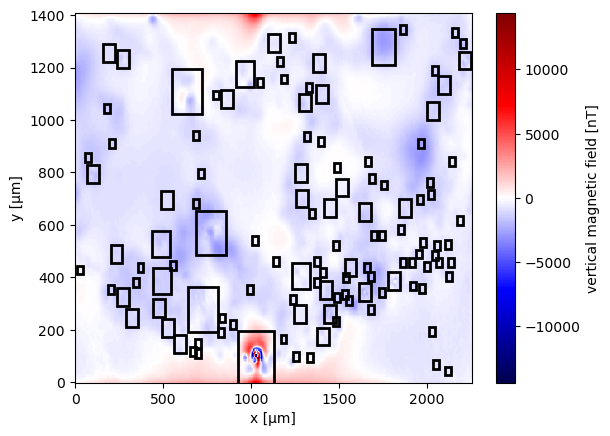

In [34]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=1.01

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    print(r2, calculated_r2_itr_euler[index])


    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    bounds = ((window[0]/position[0], window[1]/position[0]),  # bounds in x
              (window[2]/position[1], window[3]/position[1]),  # bounds in y
              (None, None),  # bounds in z
              (None, None), (None, None), (None, None))  # no bounds for moment
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args, bounds=bounds,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-3))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2

        if r2 >= calculated_r2_itr_euler[index]:
            print(r2, calculated_r2_itr_euler[index])
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
            calculated_r2_itr_euler[index] = r2

    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

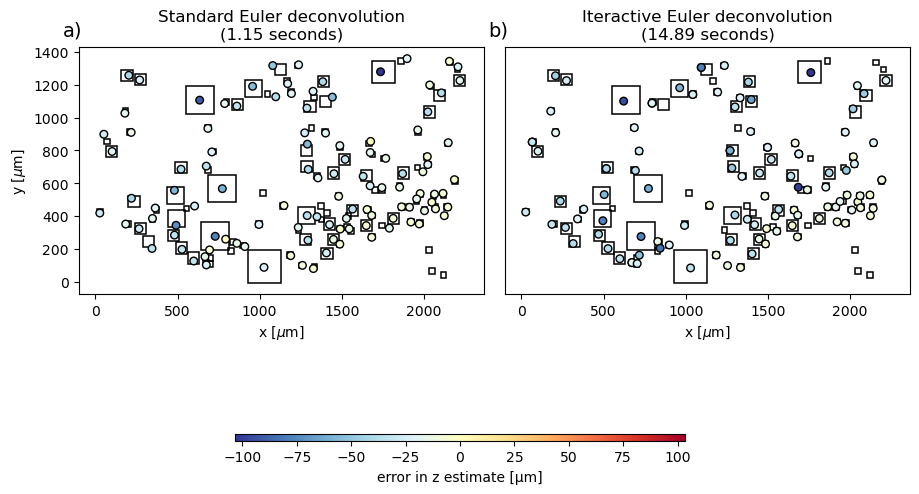

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [36]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

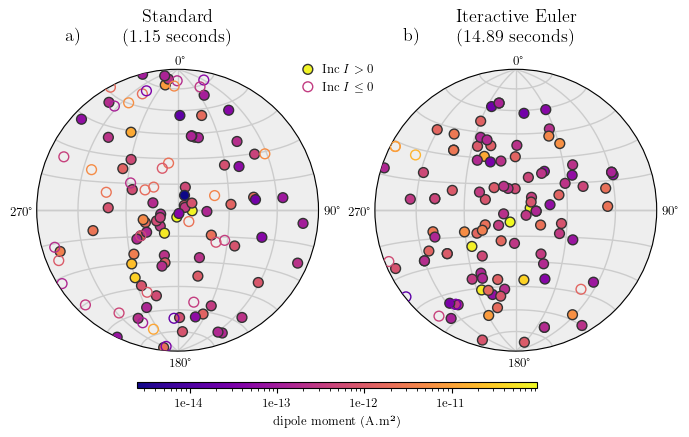

In [37]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

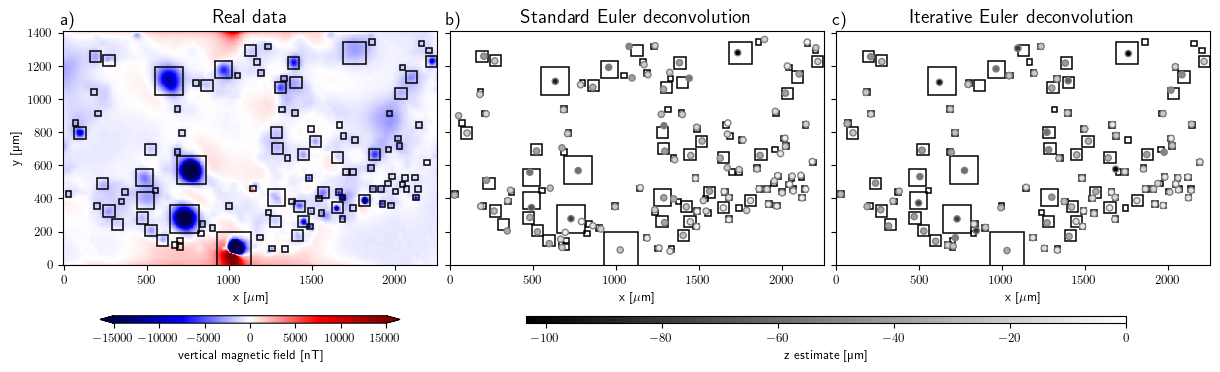

In [38]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


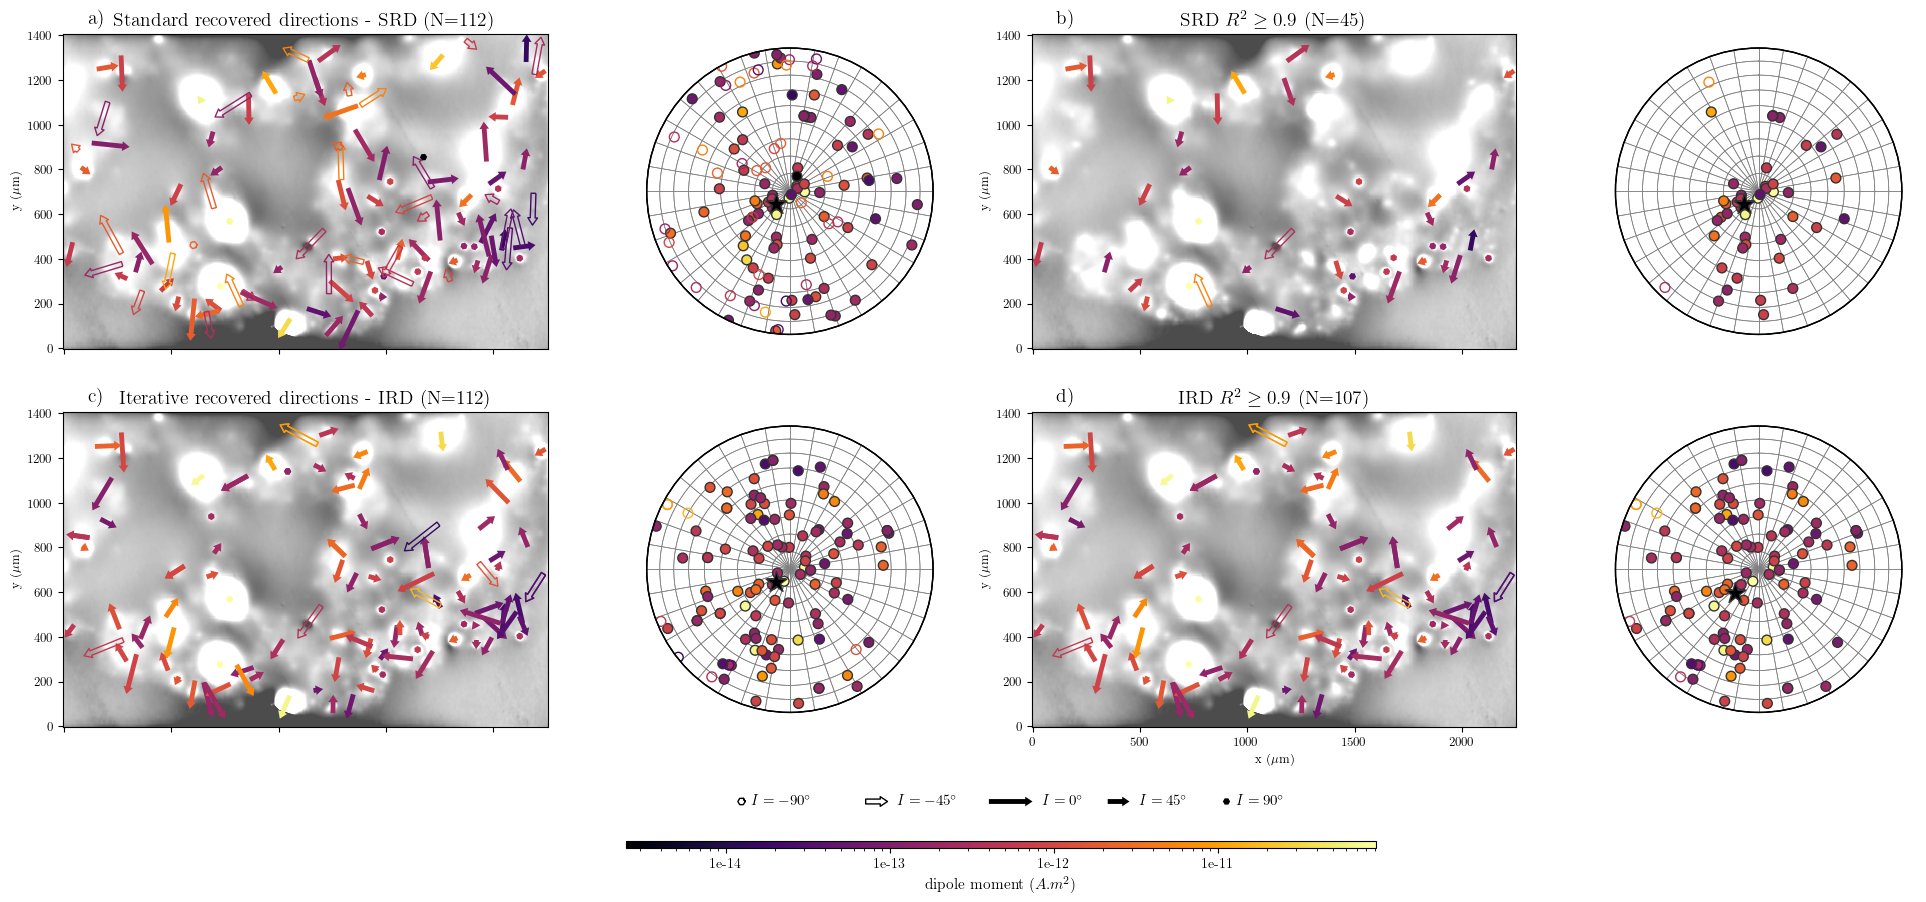

In [39]:
import warnings
warnings.filterwarnings('ignore')

r2_filter = 0.9
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= (np.array(calculated_r2) > r2_filter)

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r2_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr)[0][pos_filter], 
                                  np.array(positions_itr)[1][pos_filter], 
                                  np.array(positions_itr)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    # tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(estimated_dipole_moments)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(estimated_dipole_moments)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)

    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= (np.array(calculated_r2) > r2_filter) 

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    # tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(filter_estimated_d_m)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(filter_estimated_d_m)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    sum = np.mean(estimated_dipole_moments, axis=0)
    projection_result = mg.StereographicProjection(np.reshape(sum, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    #3
    ax = fig.add_subplot(2, 4, 6)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    # tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(estimated_dipole_moments_itr_euler)
    tmp = projection.plot(s=50, draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    sum = np.mean(estimated_dipole_moments, axis=0)
    projection_result = mg.StereographicProjection(np.reshape(sum, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= (np.array(calculated_r2_itr_euler) > r2_filter)

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    # tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})
    projection = mg.StereographicProjection(filter_estimated_d_m_itr)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(filter_estimated_d_m_itr)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r2_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r2_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [40]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [41]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 7MB
Dimensions:  (y: 300, x: 480)
Coordinates:
  * x        (x) float64 4kB 0.0 4.7 9.4 14.1 ... 2.242e+03 2.247e+03 2.251e+03
  * y        (y) float64 2kB 0.0 4.7 9.4 14.1 ... 1.396e+03 1.401e+03 1.405e+03
    z        (y, x) float64 1MB 11.0 11.0 11.0 11.0 11.0 ... 11.0 11.0 11.0 11.0
Data variables:
    bz       (y, x) float64 1MB 58.38 126.8 134.7 161.0 ... -307.7 -226.5 -76.81
    tga      (y, x) float64 1MB 50.58 80.7 61.85 74.61 ... 12.21 27.42 48.11
    x_deriv  (y, x) float64 1MB 14.55 8.116 3.64 5.254 ... 10.14 24.57 31.85
    y_deriv  (y, x) float64 1MB -19.82 -29.08 -33.49 ... 2.857 4.254 13.66
    z_deriv  (y, x) float64 1MB -44.2 -74.84 -51.87 -64.88 ... 6.174 11.4 -33.36

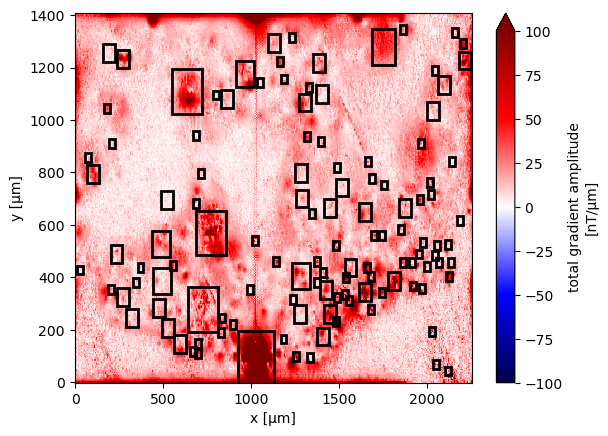

In [42]:
ax = plt.subplot(111)
scale=100
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [43]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [44]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.09,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [45]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

119 potential sources detected within 0.2041 seconds


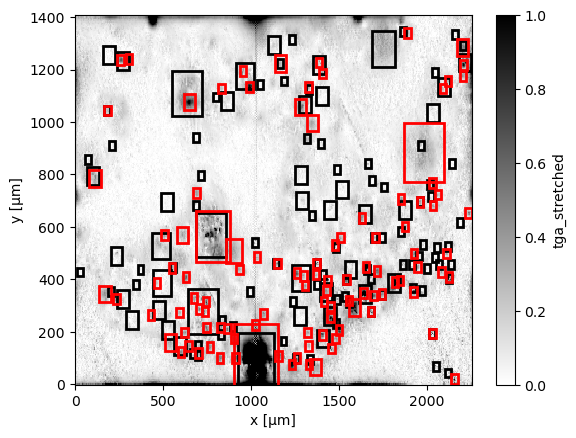

In [46]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [47]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[1137.81522369 1174.58477631   89.71522369  126.48477631]
[611.41522369 648.18477631 390.51522369 427.28477631]
[884.01522369 920.78477631 155.51522369 192.28477631]
[804.11522369 840.88477631  80.31522369 117.08477631]
[2218.81522369 2255.58477631  634.91522369  671.68477631]
[747.71522369 784.48477631 122.61522369 159.38477631]
[1053.21522369 1089.98477631  249.51522369  286.28477631]
[2.13891522e+03 2.17568478e+03 4.15223689e-01 3.71847763e+01]
[672.51522369 709.28477631 710.11522369 746.88477631]
[1302.31522369 1339.08477631  179.01522369  215.78477631]
[1317.23732969 1380.56267031  964.73732969 1028.06267031]
[1006.21522369 1042.98477631  207.21522369  243.98477631]
[1462.11522369 1498.88477631  155.51522369  192.28477631]
[857.45943568 947.34056432 462.65943568 552.54056432]
[1490.31522369 1527.08477631  540.91522369  577.68477631]
[573.81522369 610.58477631 254.21522369 290.98477631]
[579.33732969 642.66267031 537.03732969 600.36267031]
[916.91522369 953

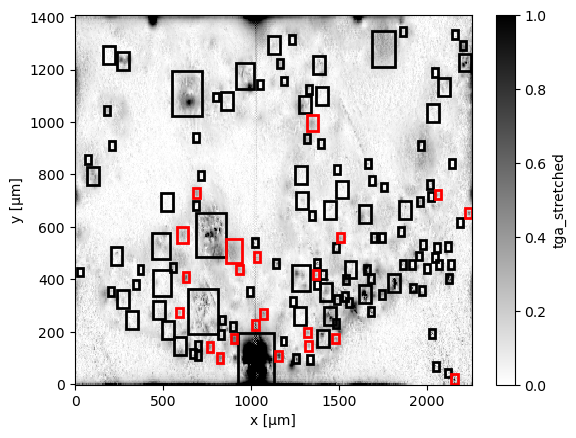

In [48]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [49]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows_filtered))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    bounds = ((window[0]/position[0], window[1]/position[0]),  # bounds in x
              (window[2]/position[1], window[3]/position[1]),  # bounds in y
              (None, None),  # bounds in z
              (None, None), (None, None), (None, None))  # no bounds for moment
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args, bounds=bounds,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    

end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[1155.78934203  112.72247866  -14.92955184]

[-2.83579325e-14  2.59124688e-14 -6.73843915e-14]

(60.313775923467404, -47.580044121037545, 7.756471232710293e-14)

0.9810176607397698

[629.61762231 407.02715233 -14.70005369]

[ 1.96437795e-14 -3.15999939e-14 -4.97268328e-14]

(53.19437932672478, 148.1333159902538, 6.210632484965255e-14)

0.9677401456431112

[920.78477631 155.51522369 -47.75641029]

[ 1.13697791e-12 -1.10027965e-12  1.99982127e-13]

(-7.203731639346752, 134.06024808827192, 1.5947811567302572e-12)

0.5580090119209102

[819.93560566  98.04923132 -20.05838842]

[-2.87398866e-14 -6.16648581e-14 -9.46917939e-14]

(54.30383619146562, -155.0113794839618, 1.1659790582603246e-13)

0.9842116299395792

[2235.85561745  654.23792842   -6.63669171]

[-1.36261156e-14 -1.05164495e-15 -7.42121644e-15]

(28.502712196762467, -94.41326112687663, 1.555157343713086e-14)

0.9112737692065251

[784.48477631 122.61522369 -83.88556103]

[-2.80061740e-13 -9.63616914e-12  3.04004232e-12]

(-17.502632304350573, -178.33524716526057, 1.0108216833616821e-11)

0.9302643203265903

[1072.35714408  228.47696489  -18.89463353]

[-9.62590856e-14 -2.67669506e-13  7.41130325e-13]

(-69.00280078454054, -160.2204424835857, 7.938431420773431e-13)

0.6892732147640713

[688.13354859 764.71259783 -17.58348684]

[-8.50094028e-14  1.70700829e-13  4.80850542e-13]

(-68.36757322994436, -26.473409464807304, 5.172838826175126e-13)

0.7143116468122386

[1324.37874762  196.35399057  -16.54495315]

[ 4.42360575e-14 -7.58600406e-15 -4.00029359e-14]

(41.71046548087897, 99.73095053868742, 6.012163600890954e-14)

0.987382275978399

[1353.45403967  985.16507901  -42.25175897]

[ 2.56786295e-13 -3.88277388e-13 -5.06073511e-13]

(47.39077223165814, 146.52144090887865, 6.876110302765189e-13)

0.9740379229232093

[1486.58574055  170.66702625   -9.52316061]

[ 1.88285863e-14 -1.80163382e-14 -6.42030499e-15]

(13.840317106434101, 133.73711638760452, 2.6838860225084826e-14)

0.936873710531856

[899.32203338 529.1538985  -69.33789385]

[ 2.86544889e-12  4.15886956e-12 -2.04770894e-12]

(22.070153109236724, 34.56672741316814, 5.449780297437619e-12)

0.9763031884756593

[1512.47793978  561.6363628   -15.69058973]

[ 1.18317714e-14  5.43891815e-14 -2.39682074e-14]

(23.29712523598977, 12.272857160729197, 6.060238313466217e-14)

0.9739953440728836

[595.41121831 270.62195212 -18.24887935]

[ 5.24633396e-14 -1.61831979e-14 -2.75091786e-14]

(26.613342842050034, 107.14325682918528, 6.140889846385474e-14)

0.9754458960511454

[602.40785505 570.4226394  -41.79201201]

[-3.92897246e-13  1.20760596e-13 -3.82449285e-13]

(42.936644785228125, -72.91470602655869, 5.61443516902675e-13)

0.9639486765358208

[925.90217719 428.55850705 -21.25068025]

[-8.43298449e-14 -5.28314604e-14 -3.82032699e-14]

(21.00205737339883, -122.06656437495351, 1.0659350721145258e-13)

0.9040954883047971

[1314.31292293  145.89424921  -10.56036435]

[-3.49302999e-14 -2.46612681e-15  5.43938690e-16]

(-0.889929595355813, -94.03845909910184, 3.5021471980148365e-14)

0.7606214045151428

[1362.36713884  420.19443778  -13.57069687]

[-1.66624580e-14 -2.10600480e-15 -2.76674627e-14]

(58.7409295102424, -97.20354311511188, 3.236605092666655e-14)

0.7604058754236822

[2069.36680932  725.04779682  -15.38669543]

[ 3.29807458e-14  7.75222679e-15 -1.78085331e-14]

(27.72829808620827, 76.77256525819988, 3.8274932608982695e-14)

0.9681669740597191

[1052.38477631  502.48477631  -72.96058679]

[2.32434472e-12 2.14885696e-12 1.55373611e-12]

(-26.14364516859118, 47.24661336109029, 3.5262246815938373e-12)

0.8458638449534439

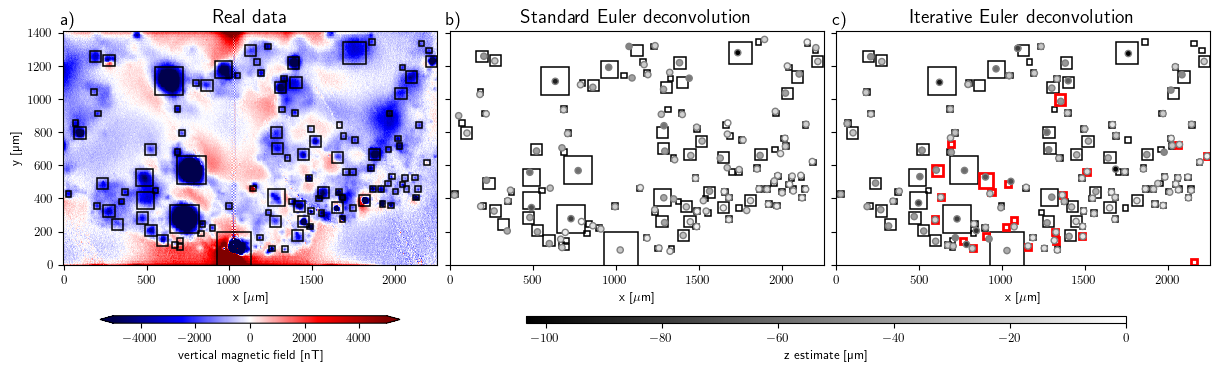

In [50]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-5000, vmax=5000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="r",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:33: DeprecationWarning: invalid escape sequence '\m'
<>:60: DeprecationWarning: invalid escape sequence '\m'
<>:76: DeprecationWarning: invalid escape sequence '\m'
<>:77: DeprecationWarning: invalid escape sequence '\m'
<>:106: DeprecationWarning: invalid escape sequence '\m'
<>:107: DeprecationWarning: invalid escape sequence '\m'
<>:241: DeprecationWarning: invalid escape sequence '\c'
<>:243: DeprecationWarning: invalid escape sequence '\c'
<>:245: DeprecationWarning: invalid escape sequence '\c'
<>:247: DeprecationWarning: invalid escape sequence '\c'
<>:249: DeprecationWarning: invalid escape sequence '\c'
<>:252: DeprecationWarning: invalid escape sequence '\g'
<>:253: DeprecationWarning: invalid escape sequence '\g'
<>:33: DeprecationWarning: invalid escape sequence '\m'
<>:60: DeprecationWarning: invalid escape sequence '\m'
<>:76: DeprecationWarning: invalid escape sequence '\m'
<>:77: DeprecationWarning: invalid escape sequence '\m'
<>:106: DeprecationWarning: invalid esc

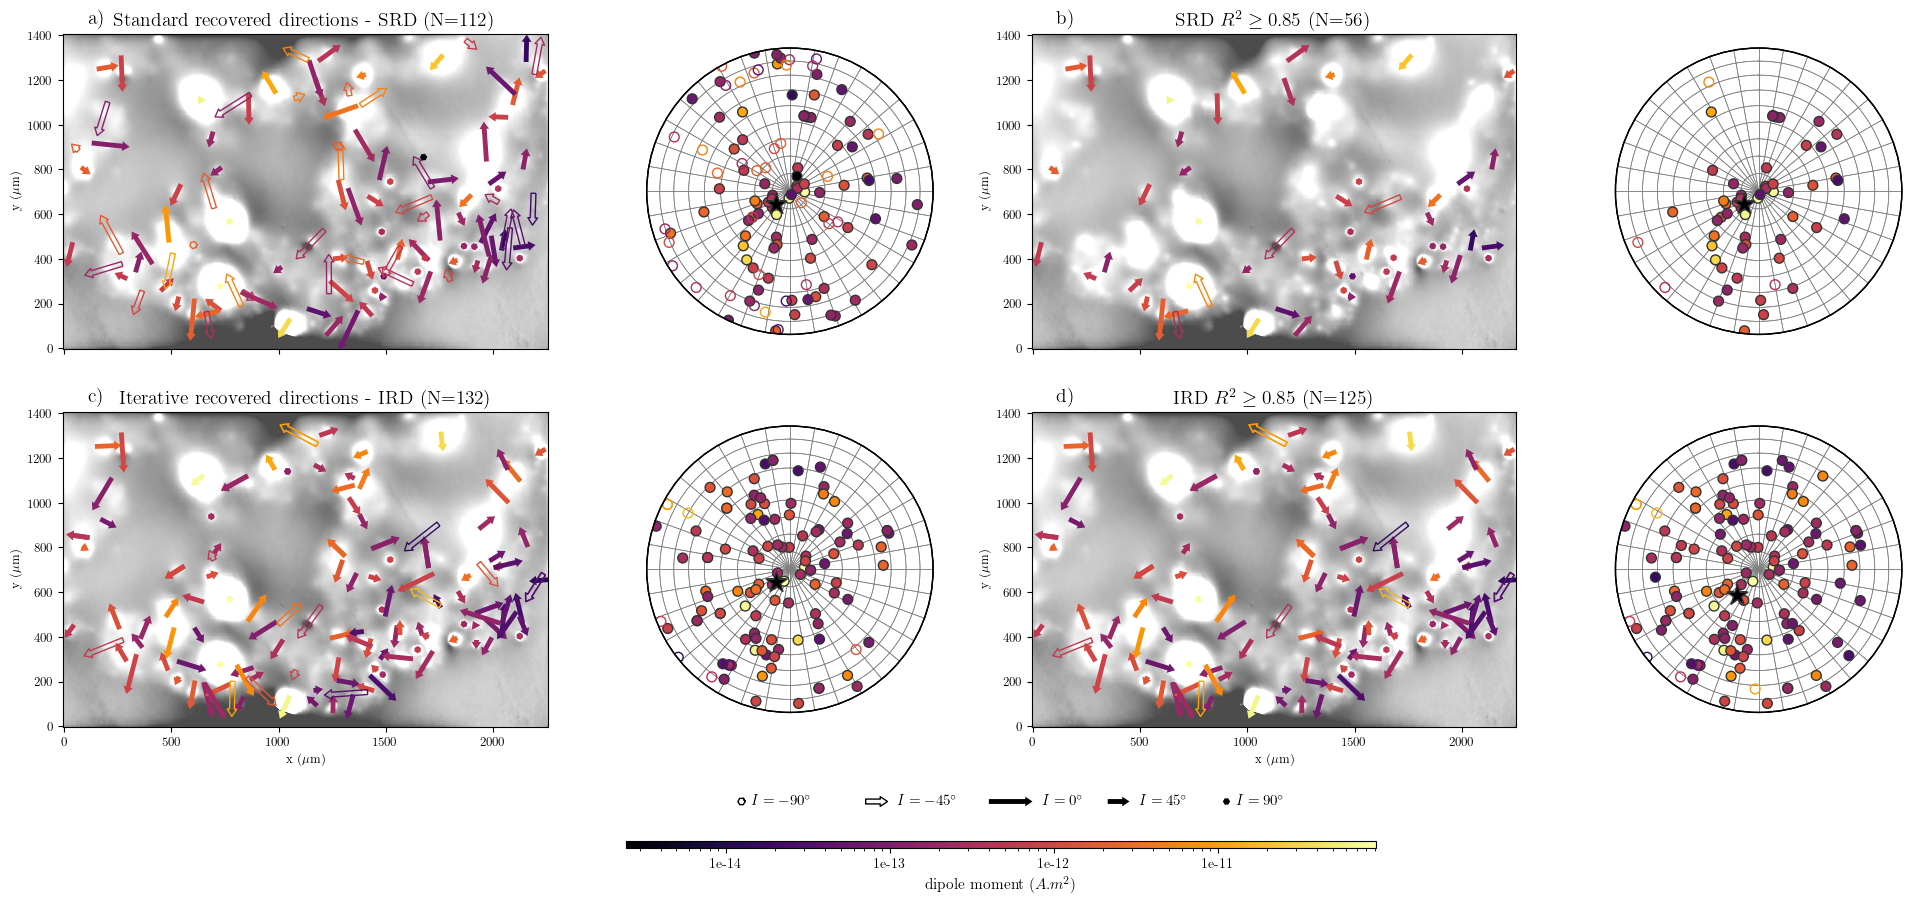

In [51]:
import warnings
warnings.filterwarnings('ignore')

r2_filter = 0.85
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= (np.array(calculated_r2) > r2_filter)

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")
    # plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > r2_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    # tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(estimated_dipole_moments)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(estimated_dipole_moments)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)

    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= (np.array(calculated_r2) > r2_filter) 

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    # tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(filter_estimated_d_m)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(filter_estimated_d_m)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    sum = np.mean(estimated_dipole_moments, axis=0)
    projection_result = mg.StereographicProjection(np.reshape(sum, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    #3
    ax = fig.add_subplot(2, 4, 6)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    # tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    projection = mg.StereographicProjection(estimated_dipole_moments_itr_euler)
    tmp = projection.plot(s=50, draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))    
    sum = np.mean(estimated_dipole_moments, axis=0)
    projection_result = mg.StereographicProjection(np.reshape(sum, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= (np.array(calculated_r2_itr_euler_enhanced) > r2_filter)

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    # tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})
    projection = mg.StereographicProjection(filter_estimated_d_m_itr)
    tmp = projection.plot(draw_cross=False, add_radial_grid=True, add_ticks=False, **kwargs)
    
    # plot resulting vector
    incs, decs, amps = mg.vector_to_angles(filter_estimated_d_m_itr)
    # amps = amps/abs(amps)
    unit = mg.angles_to_vector(incs, decs, amps)
    sum = np.sum(unit, axis=0)
    R = np.sqrt(sum[0]**2+sum[1]**2+sum[2]**2)
    projection_result = mg.StereographicProjection(np.reshape(sum/R, (1,3)))
    tmp_result = projection_result.plot(ax=ax, s=250, marker='*',draw_cross=False, add_radial_grid=True, add_ticks=False)


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r2_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r2_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

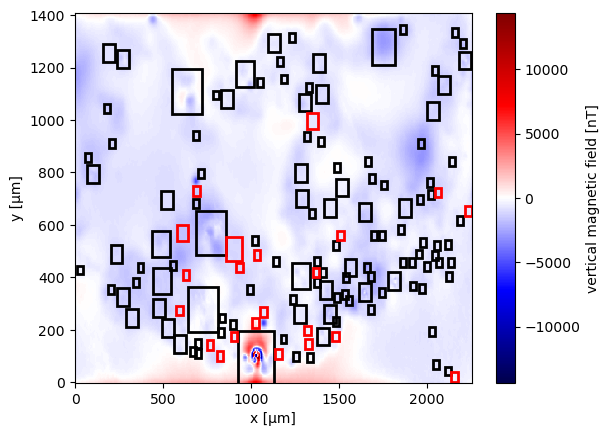

In [52]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [53]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([0.9971513 , 0.99816205, 0.99418089, 0.99713504, 0.98616474,
       0.98590709, 0.99121824, 0.99571853, 0.93546979, 0.9915563 ,
       0.99627063, 0.9915591 , 0.95524707, 0.99680762, 0.99725967,
       0.98666132, 0.98830085, 0.96498328, 0.99594604, 0.99413512,
       0.99131464, 0.97099504, 0.96641811, 0.96265001, 0.99162009,
       0.96232853, 0.99235493, 0.99098663, 0.96617519, 0.99352723,
       0.95433064, 0.99831189, 0.99483487, 0.99628916, 0.95415038,
       0.99163711, 0.98243254, 0.97734166, 0.97449636, 0.98031287,
       0.99326936, 0.99741221, 0.98938332, 0.98033925, 0.99265391,
       0.95666974, 0.94065698, 0.98210193, 0.94215723, 0.99202402,
       0.91708691, 0.98457073, 0.99132513, 0.99626383, 0.88552903,
       0.97698581, 0.98517371, 0.99631762, 0.98830195, 0.99328143,
       0.96913976, 0.99843363, 0.96998052, 0.98959805, 0.97070541,
       0.94785139, 0.93677818, 0.99505972, 0.9783604 , 0.95252511,
       0.93495113, 0.96987602, 0.93852427, 0.99654395, 0.99654

# Show the observed and predicted data

In [54]:
# pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))
# filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
#                                           np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
#                                           np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
#                                          ]).T
# filter_position_d_m_itr = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
#                                           np.array(positions_itr_enhanced)[1][pos_filter], 
#                                           np.array(positions_itr_enhanced)[2][pos_filter]
#                                          ])

In [55]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

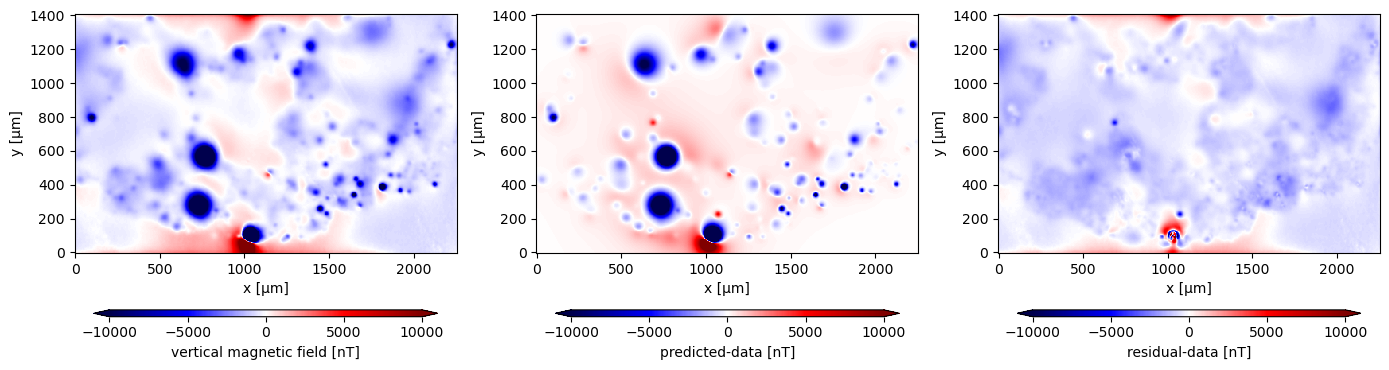

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
 R2 = 0.9971512973745011
Individual source:   R2 = 0.9973657138455043


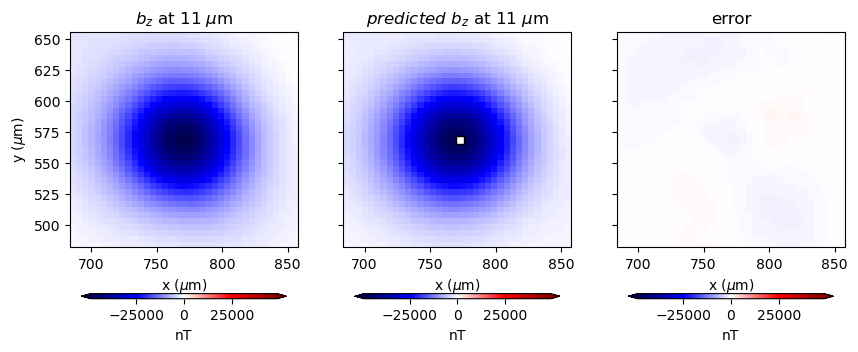

2
 R2 = 0.9981620451899793
Individual source:   R2 = 0.9981881883611224


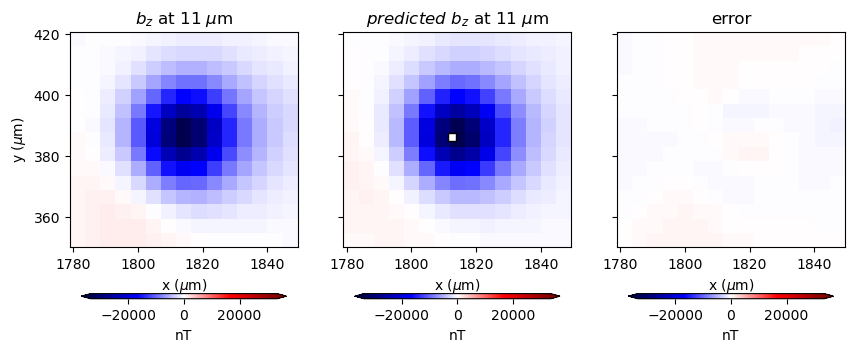

3
 R2 = 0.9941808918075986
Individual source:   R2 = 0.9923792694960564


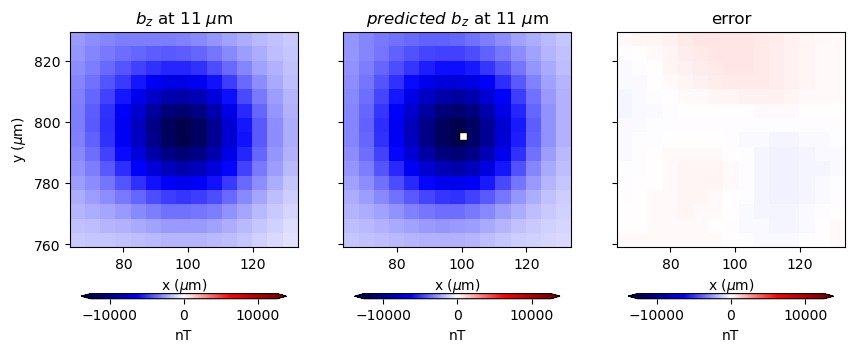

4
 R2 = 0.9971350359461373
Individual source:   R2 = 0.9945589564406836


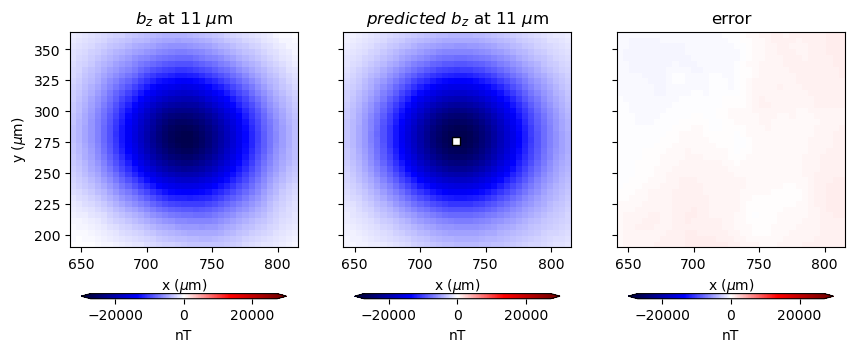

5
 R2 = 0.9861647413826521
Individual source:   R2 = 0.9903086854435353


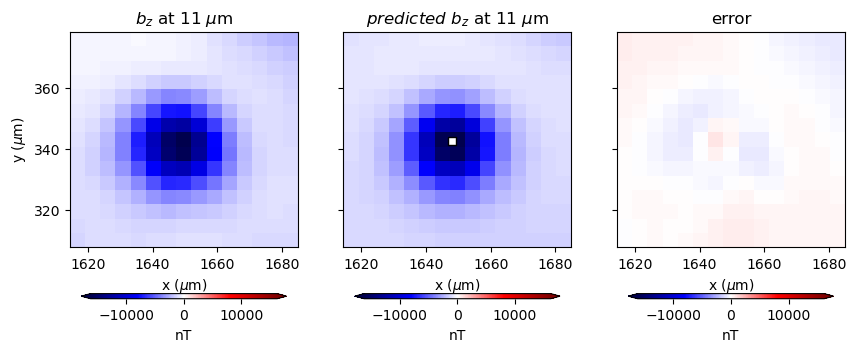

6
 R2 = 0.9859070860730715
Individual source:   R2 = 0.9862676416470245


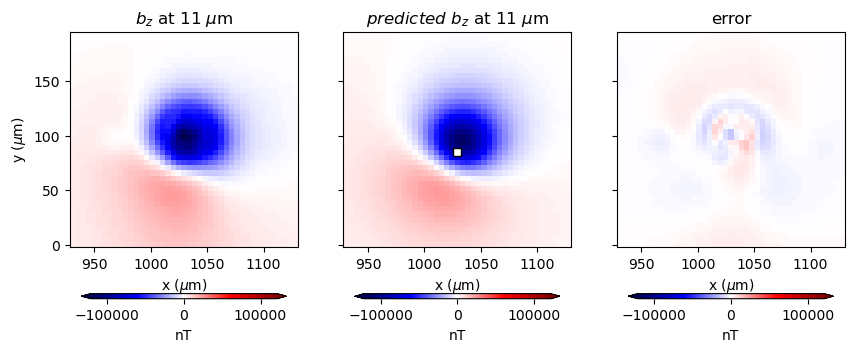

7
 R2 = 0.991218237428396
Individual source:   R2 = 0.9913505220062557


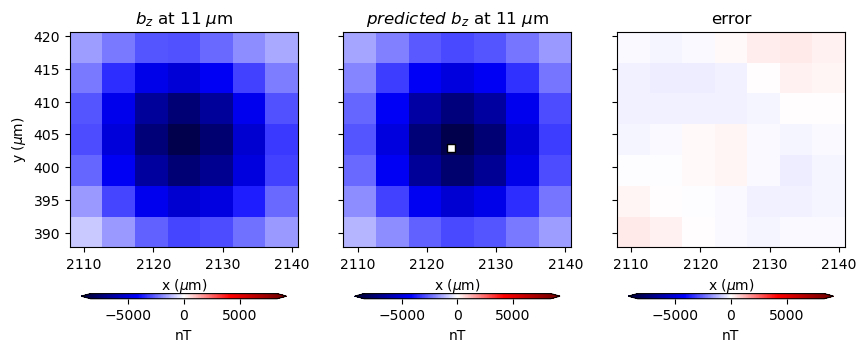

8
 R2 = 0.9957185270689398
Individual source:   R2 = 0.9941253922965755


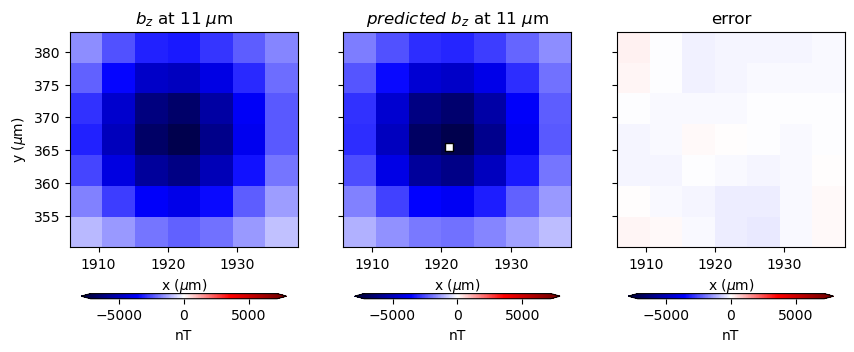

9
 R2 = 0.935469791441713
Individual source:   R2 = 0.9837576851445757


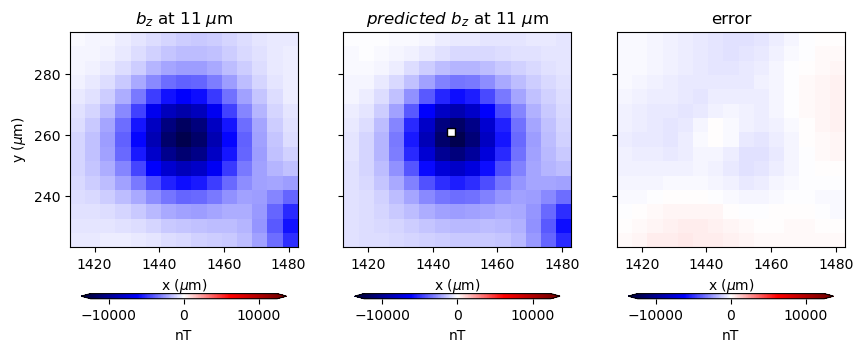

10
 R2 = 0.9915563042150484
Individual source:   R2 = 0.9919334803450559


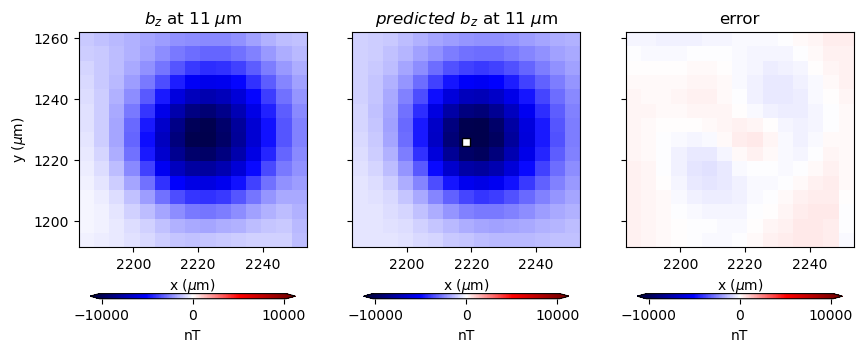

11
 R2 = 0.9962706290209722
Individual source:   R2 = 0.9576437497028181


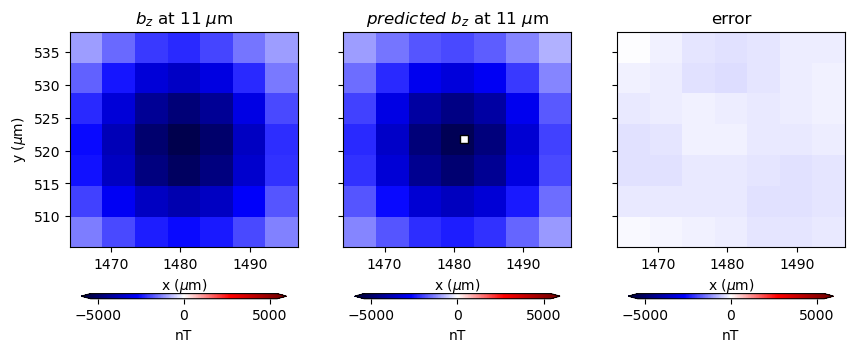

12
 R2 = 0.9915590961898357
Individual source:   R2 = 0.985984438984455


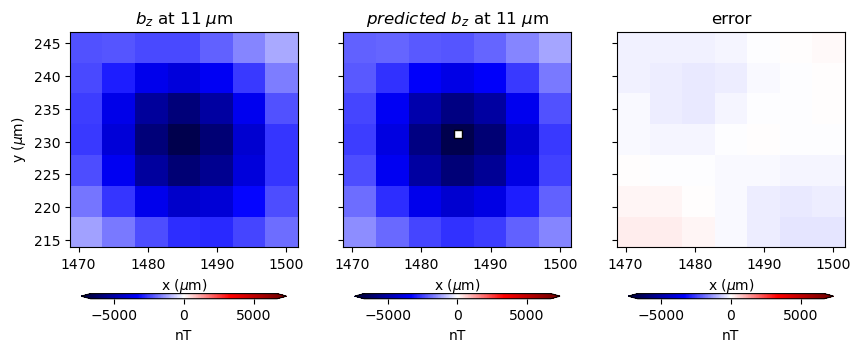

13
 R2 = 0.9552470678803675
Individual source:   R2 = 0.9633294681634703


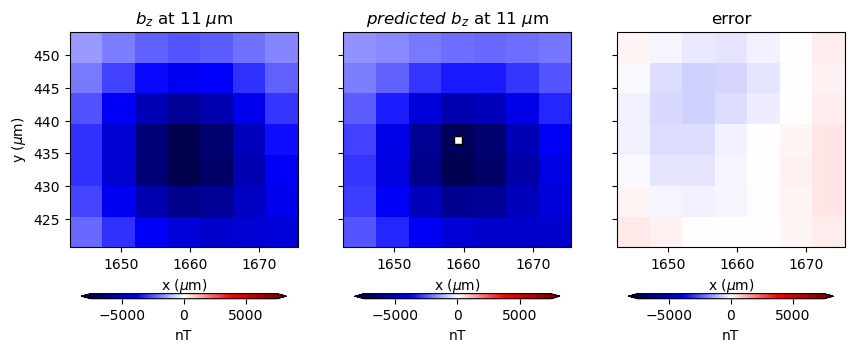

14
 R2 = 0.9968076238311847
Individual source:   R2 = 0.9957400584365546


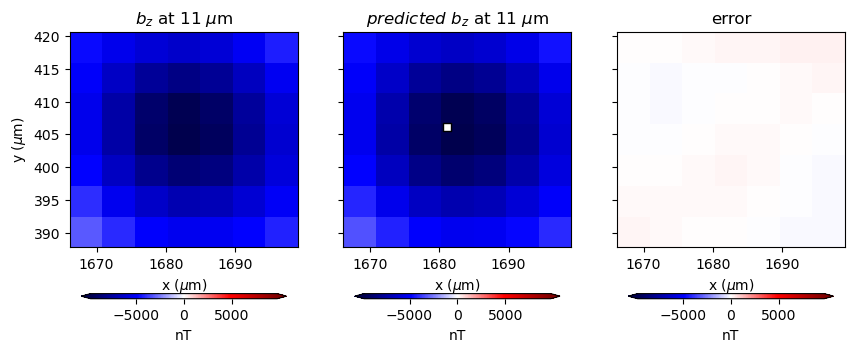

15
 R2 = 0.9972596702195797
Individual source:   R2 = 0.9886497434311364


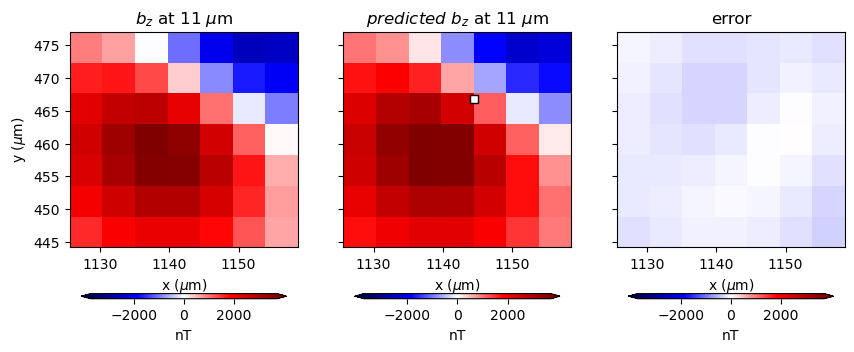

16
 R2 = 0.9866613204327707
Individual source:   R2 = 0.9895976570919338


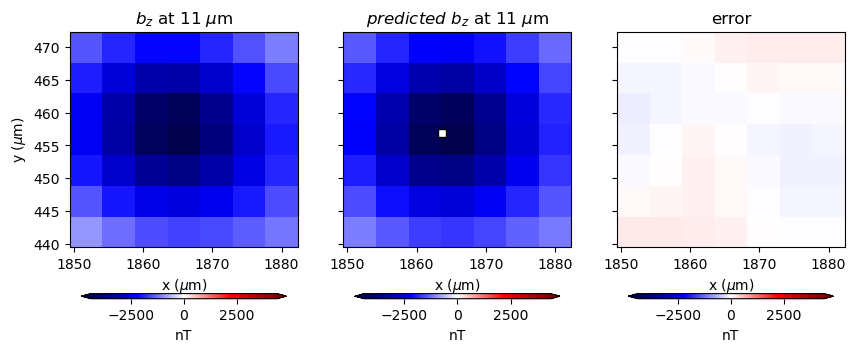

17
 R2 = 0.988300850920281
Individual source:   R2 = 0.98783794278724


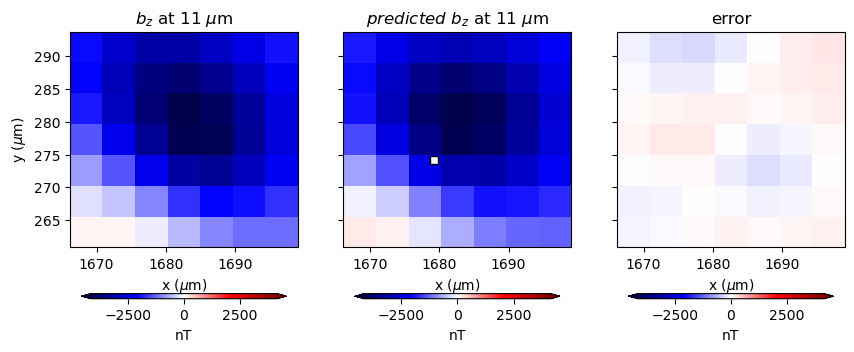

18
 R2 = 0.9649832821090214
Individual source:   R2 = 0.9566865685885971


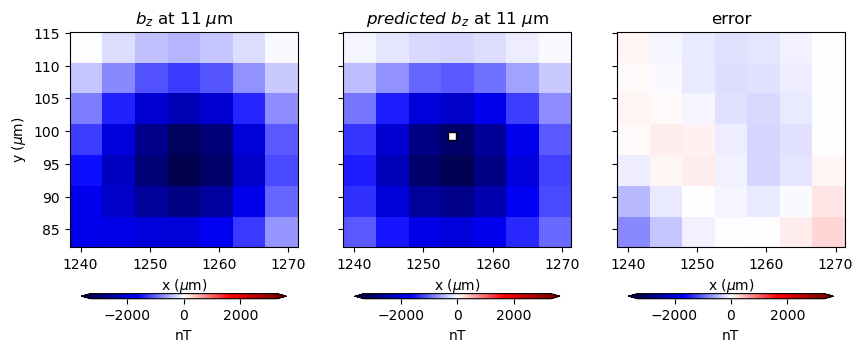

19
 R2 = 0.9959460371811352
Individual source:   R2 = 0.9776655987338428


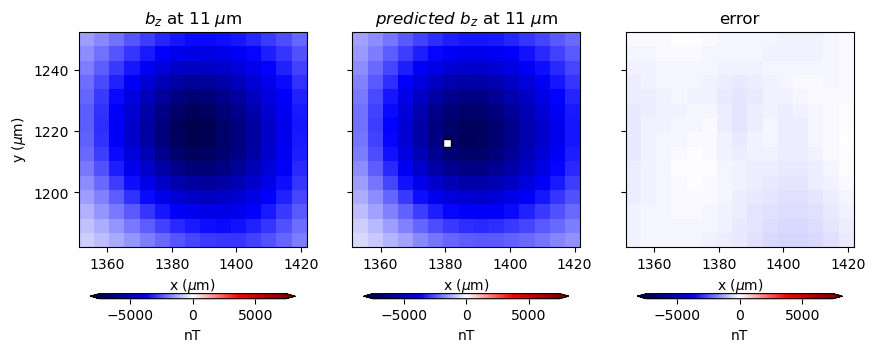

20
 R2 = 0.9941351185772431
Individual source:   R2 = 0.9941269189699822


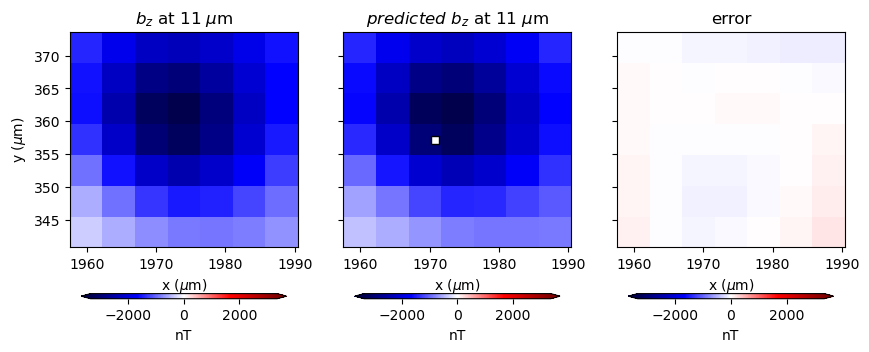

21
 R2 = 0.9913146434951793
Individual source:   R2 = 0.8083943623673626


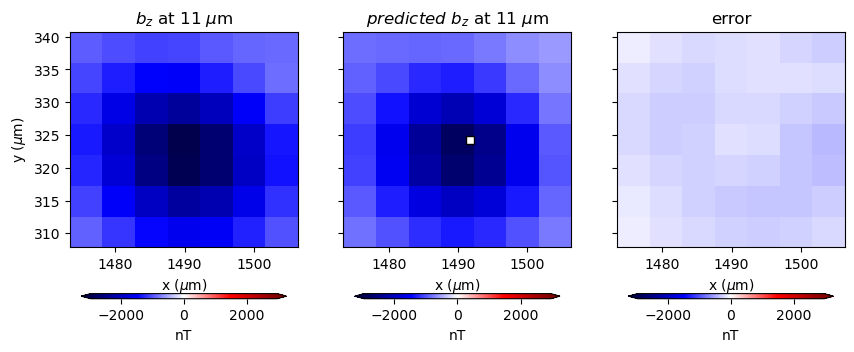

22
 R2 = 0.9709950382554942
Individual source:   R2 = 0.9715568317475508


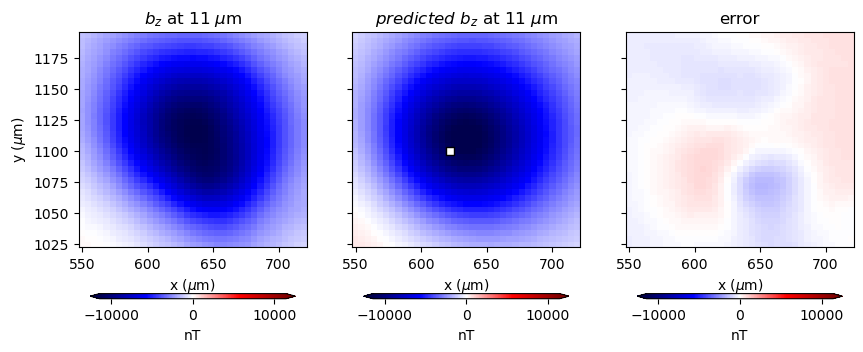

23
 R2 = 0.9664181108401455
Individual source:   R2 = 0.9604834220195942


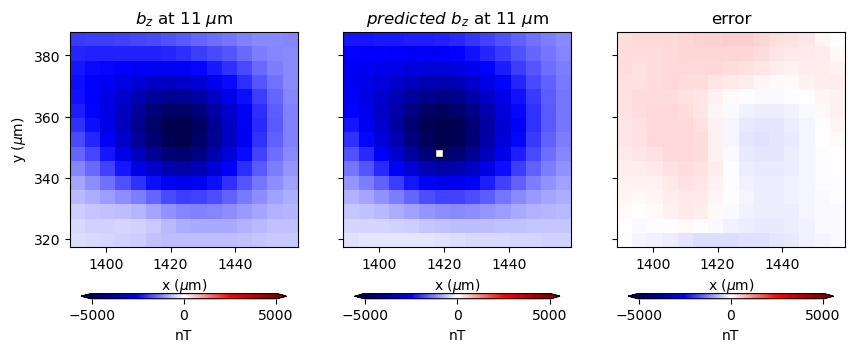

24
 R2 = 0.9626500114108113
Individual source:   R2 = 0.9342373195844415


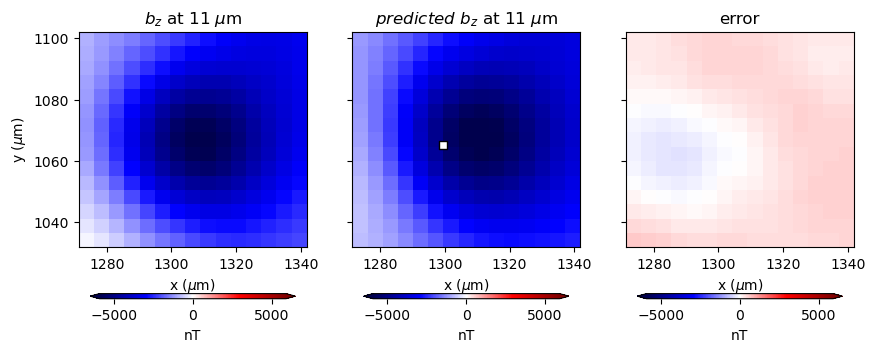

25
 R2 = 0.9916200890900502
Individual source:   R2 = 0.9851548972362438


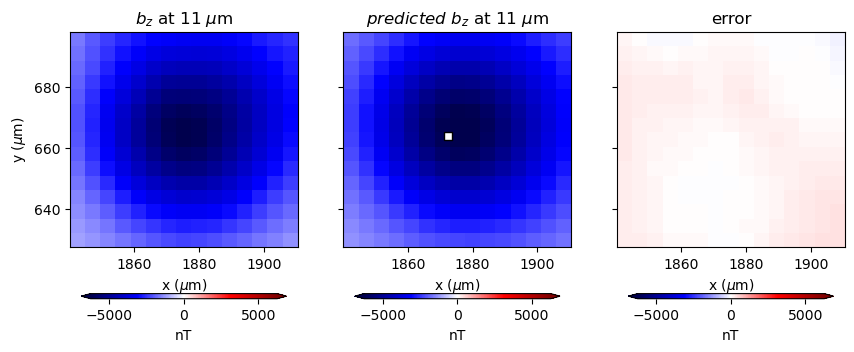

26
 R2 = 0.9623285325261786
Individual source:   R2 = 0.9636323029090291


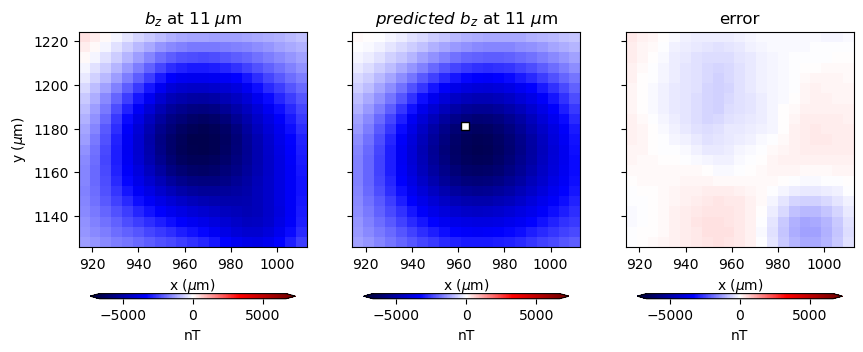

27
 R2 = 0.9923549266619096
Individual source:   R2 = 0.9528833799631823


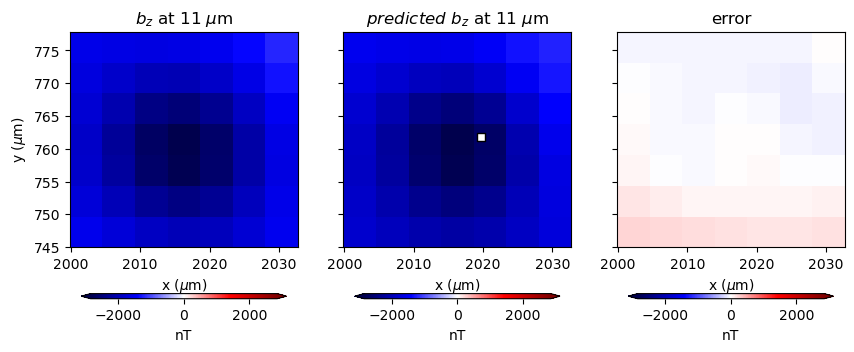

28
 R2 = 0.9909866279619441
Individual source:   R2 = 0.7884508261928385


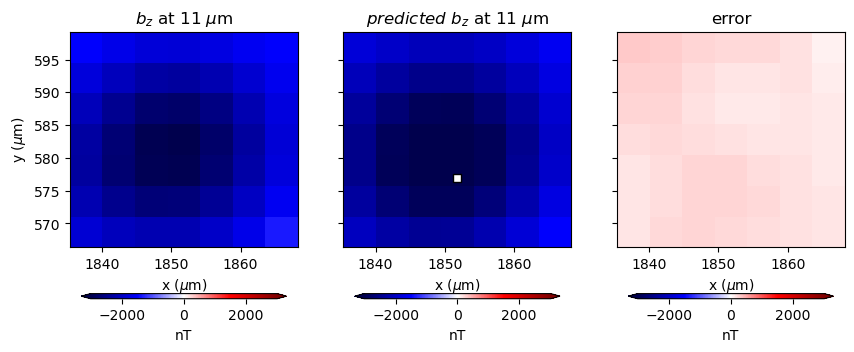

29
 R2 = 0.966175190456566
Individual source:   R2 = 0.965631753625723


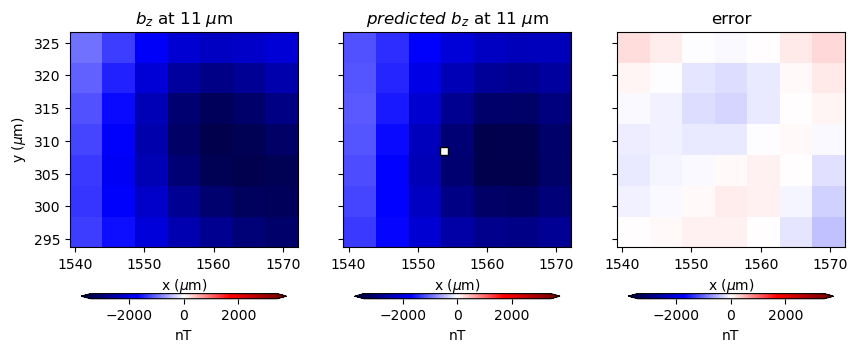

30
 R2 = 0.9935272282195056
Individual source:   R2 = 0.9863164570689582


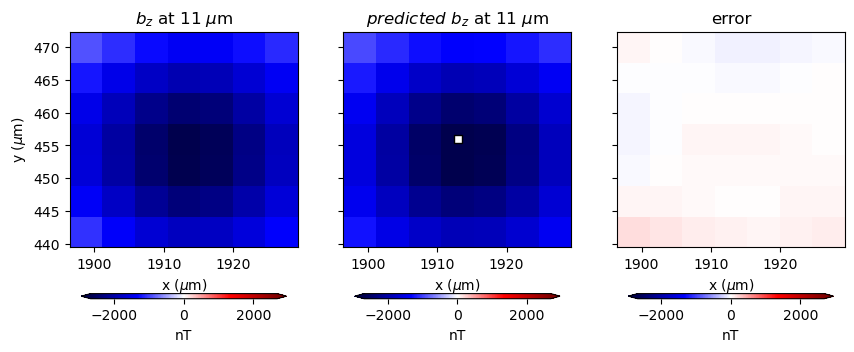

31
 R2 = 0.9543306410310379
Individual source:   R2 = 0.8541455539063896


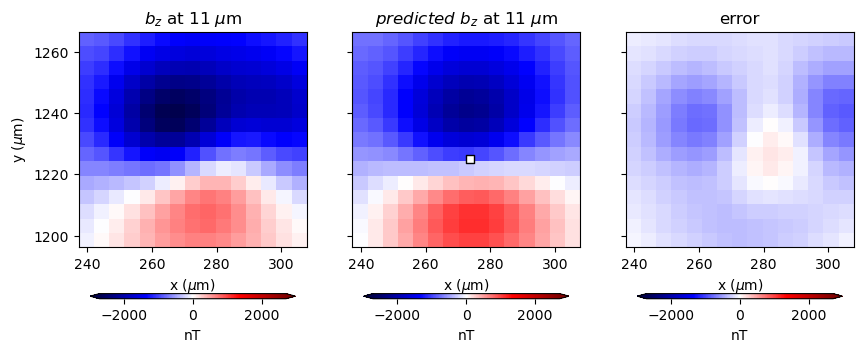

32
 R2 = 0.998311887620858
Individual source:   R2 = -0.0463804393969276


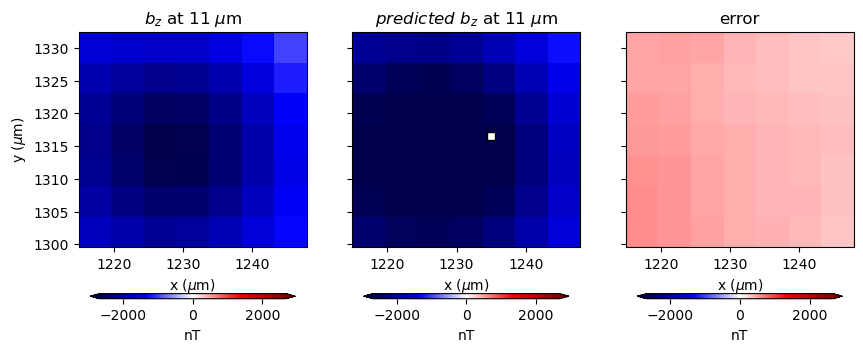

33
 R2 = 0.9948348721114791
Individual source:   R2 = 0.9446015495371023


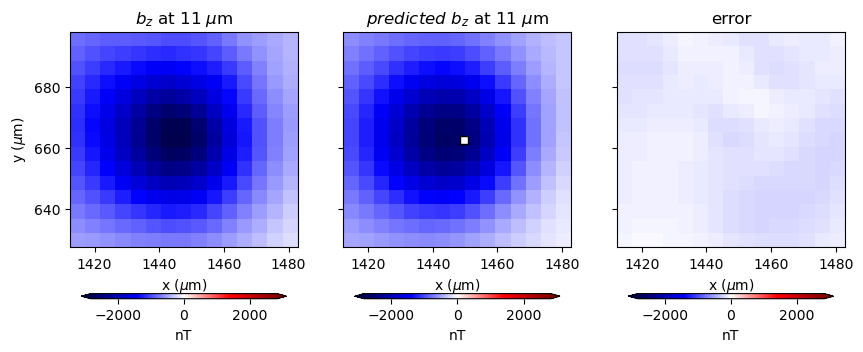

34
 R2 = 0.9962891567492846
Individual source:   R2 = 0.948683075563237


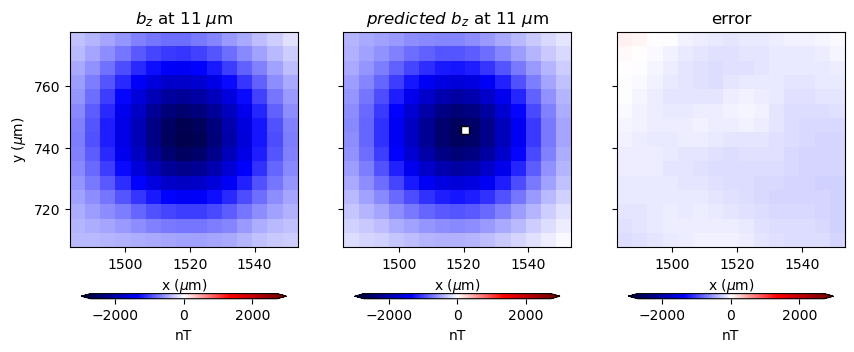

35
 R2 = 0.9541503792146283
Individual source:   R2 = 0.07725003421713639


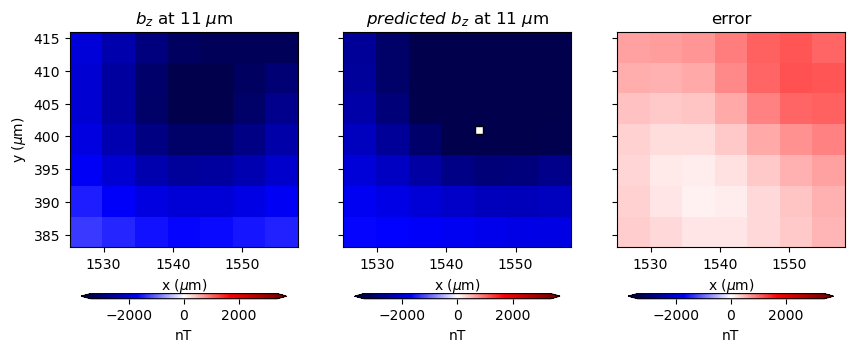

36
 R2 = 0.9916371110534496
Individual source:   R2 = 0.9339026696593391


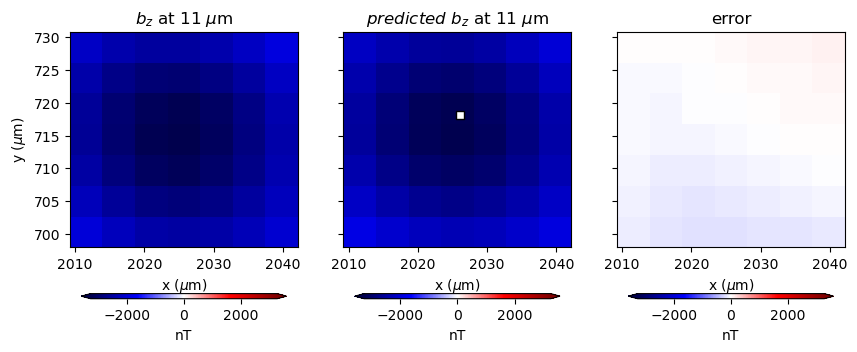

37
 R2 = 0.9824325399465487
Individual source:   R2 = 0.9811878173810098


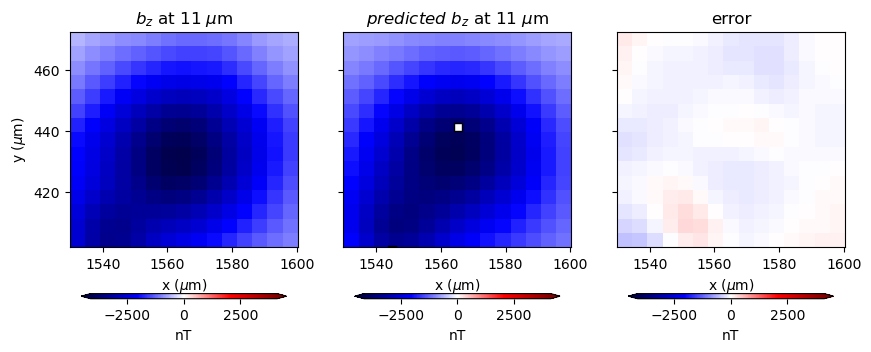

38
 R2 = 0.9773416620599662
Individual source:   R2 = 0.9705213551703817


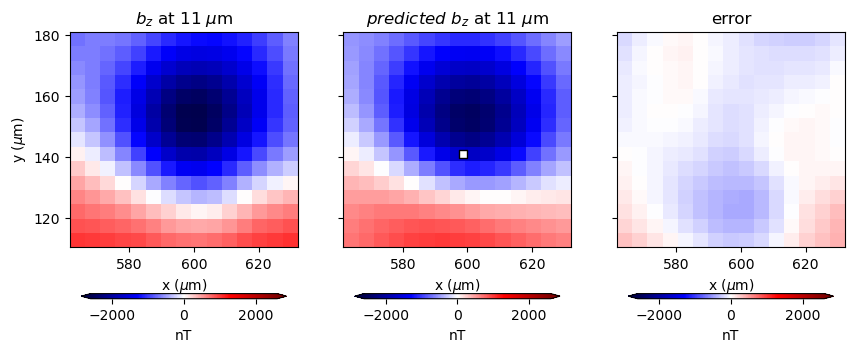

39
 R2 = 0.9744963550127201
Individual source:   R2 = 0.5759919903431372


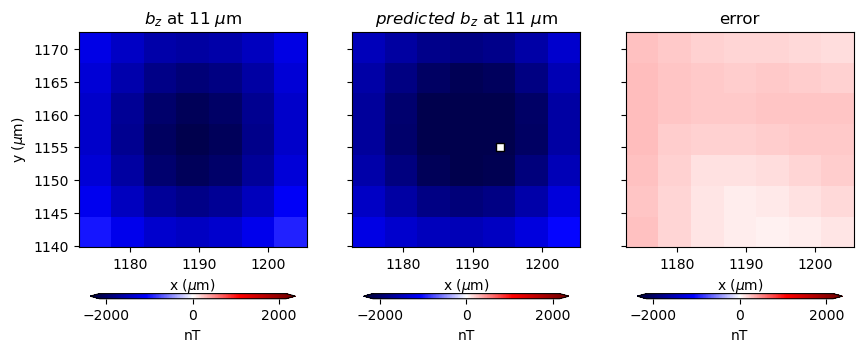

40
 R2 = 0.9803128688775149
Individual source:   R2 = 0.9539258001229457


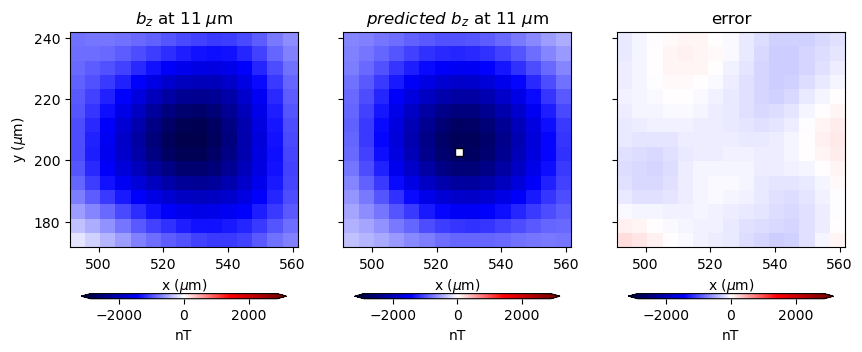

41
 R2 = 0.9932693582210907
Individual source:   R2 = -2.202642333584303


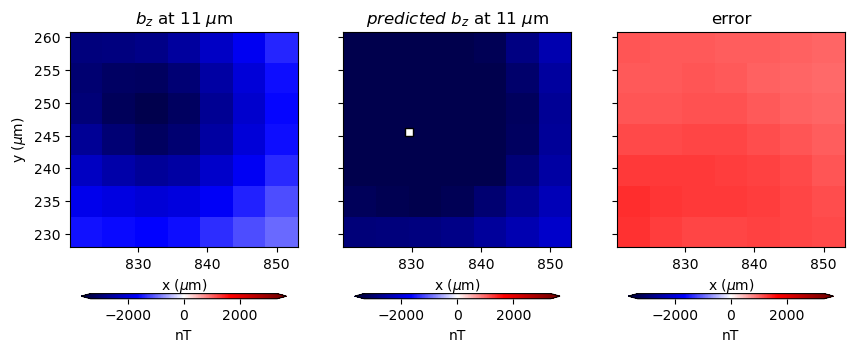

42
 R2 = 0.9974122126208682
Individual source:   R2 = 0.9830709727291983


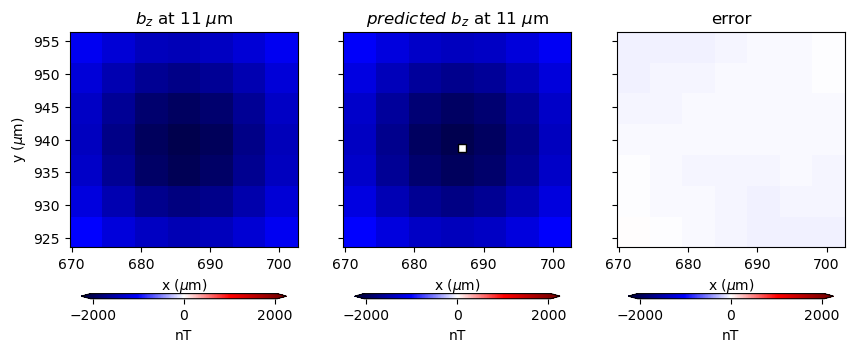

43
 R2 = 0.9893833196520483
Individual source:   R2 = 0.9075809980028777


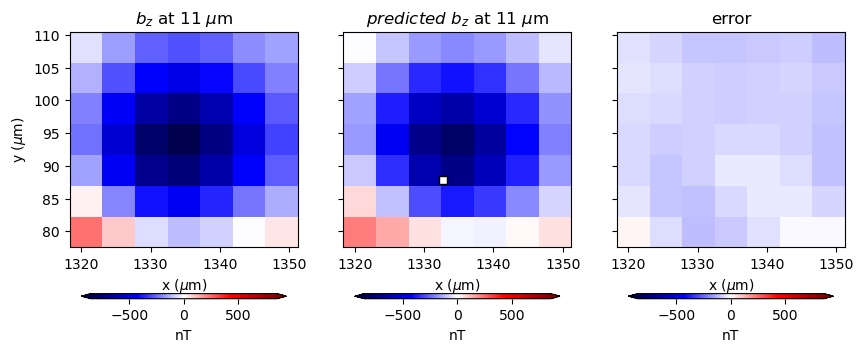

44
 R2 = 0.9803392548658975
Individual source:   R2 = 0.6966301514119665


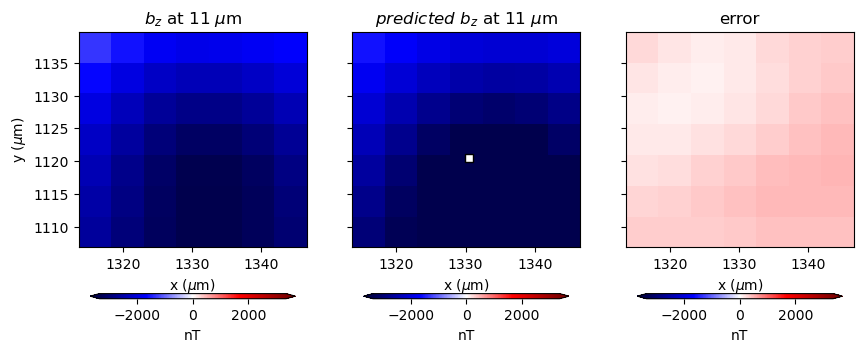

45
 R2 = 0.992653908495393
Individual source:   R2 = 0.9402586715464637


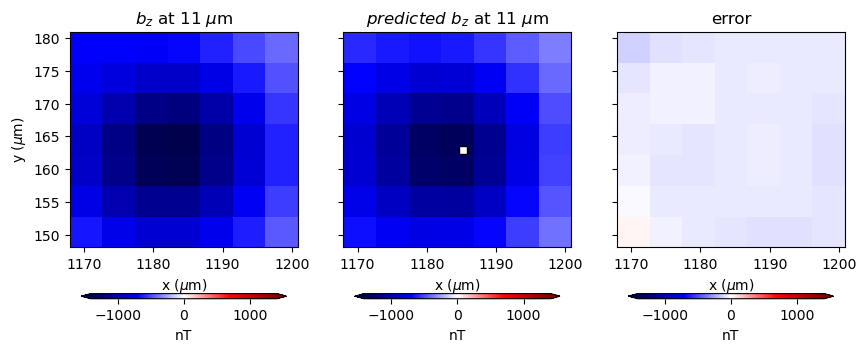

46
 R2 = 0.9566697407104241
Individual source:   R2 = 0.9288484649535266


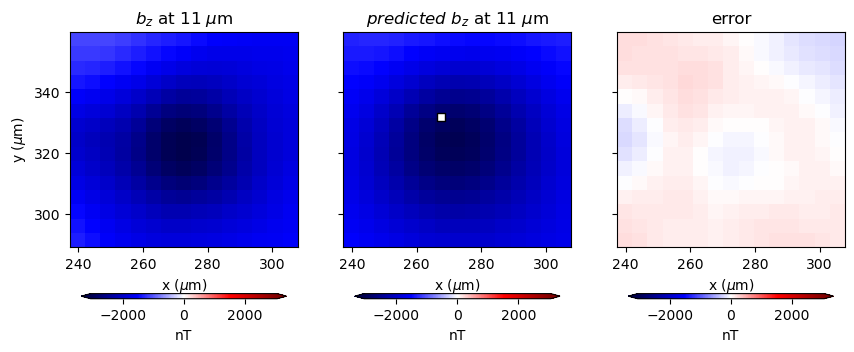

47
 R2 = 0.9406569816859107
Individual source:   R2 = 0.9260946092329033


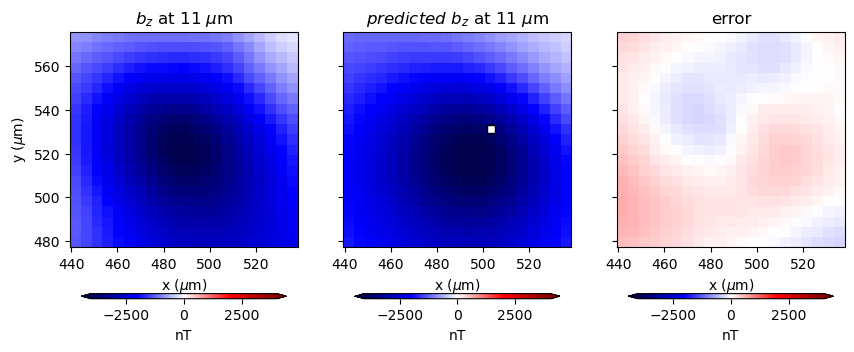

48
 R2 = 0.9821019254886645
Individual source:   R2 = 0.967081389942357


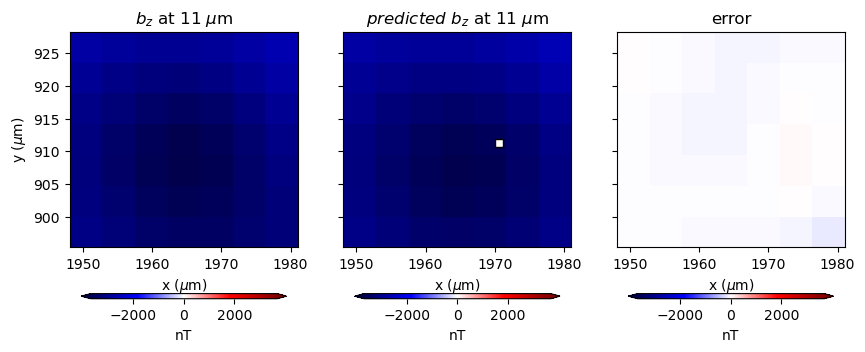

49
 R2 = 0.9421572262598426
Individual source:   R2 = 0.9308719285085603


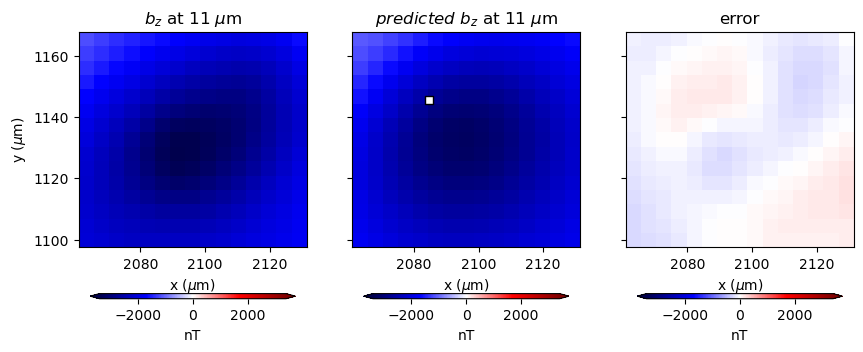

50
 R2 = 0.9920240168474576
Individual source:   R2 = -1.9856075548254033


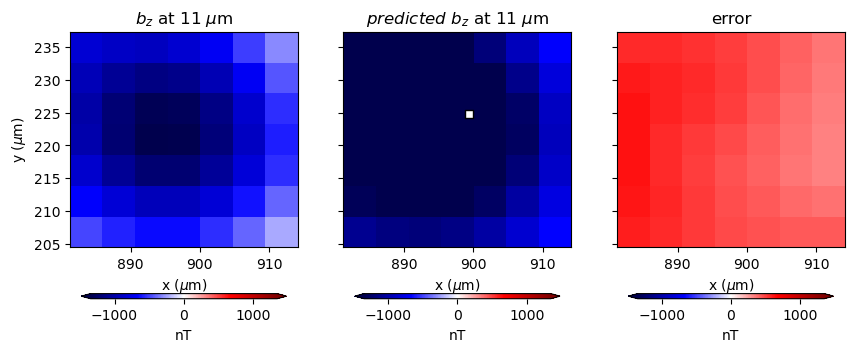

51
 R2 = 0.9170869098270484
Individual source:   R2 = 0.8774395286956508


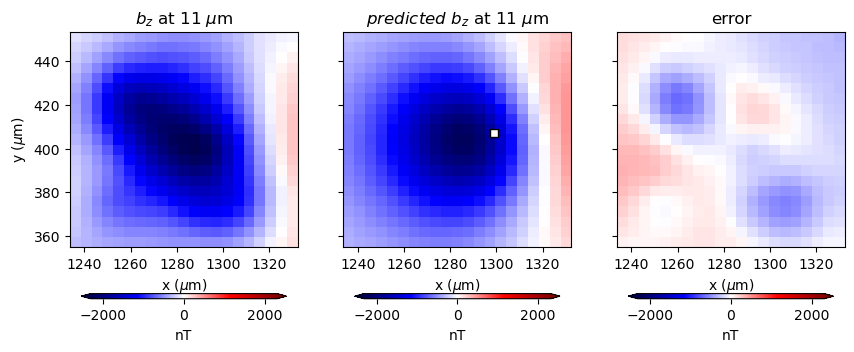

52
 R2 = 0.9845707297305006
Individual source:   R2 = 0.9630845039705725


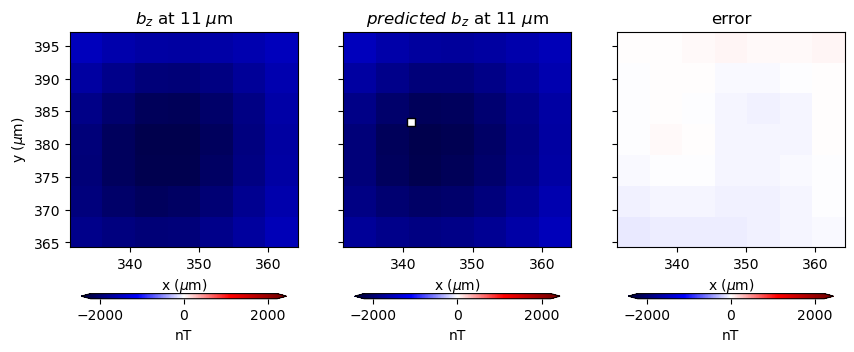

53
 R2 = 0.9913251338379164
Individual source:   R2 = 0.7695927515426346


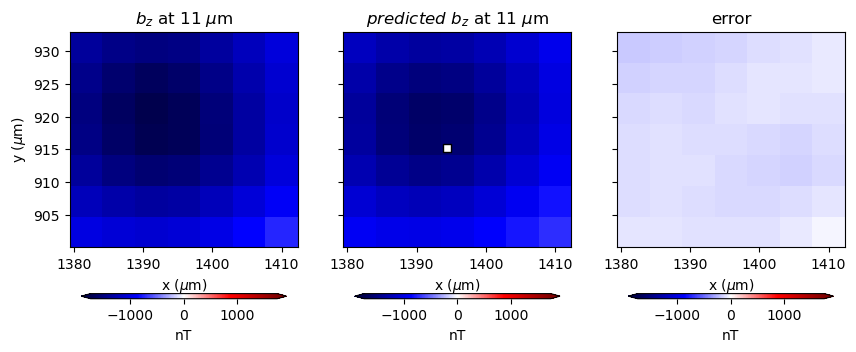

54
 R2 = 0.9962638289006273
Individual source:   R2 = 0.9957888920792293


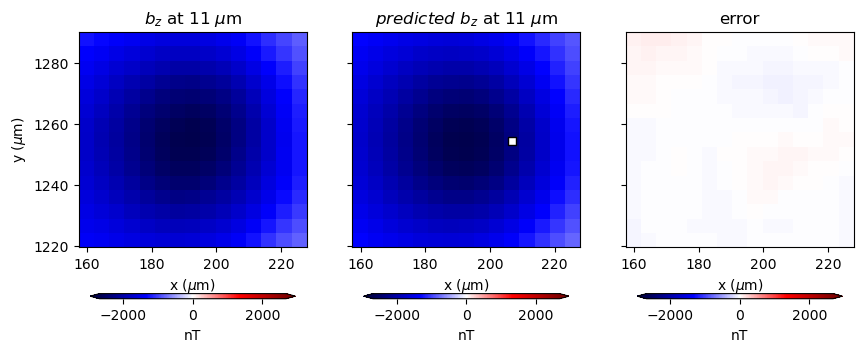

55
 R2 = 0.885529034957047
Individual source:   R2 = 0.8913107103056064


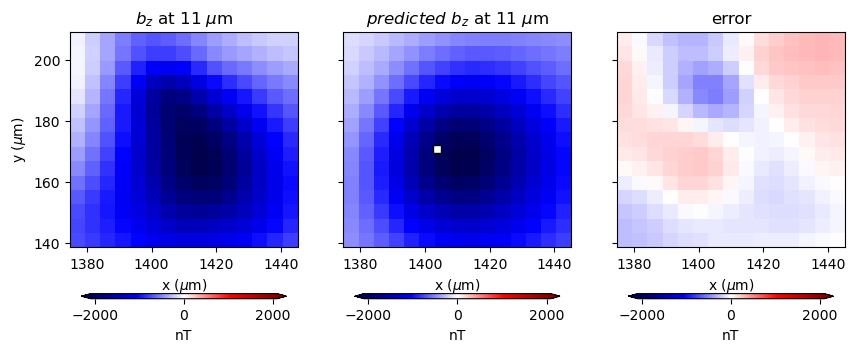

56
 R2 = 0.976985814561853
Individual source:   R2 = 0.7575889503030849


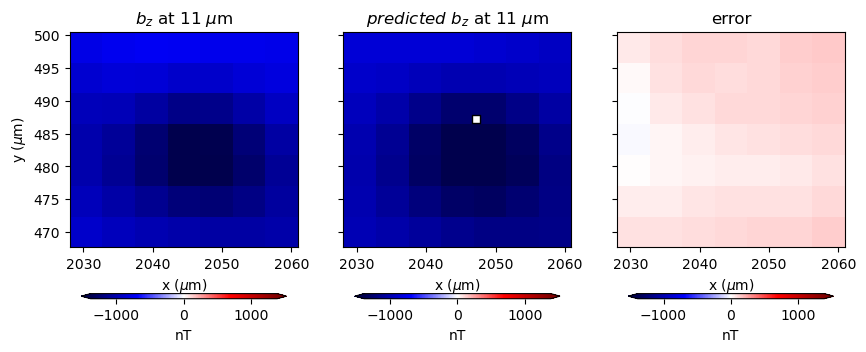

57
 R2 = 0.985173710517607
Individual source:   R2 = 0.9204657813909212


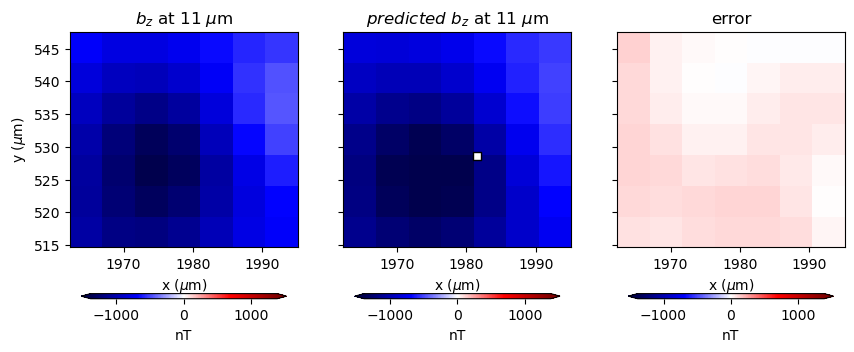

58
 R2 = 0.9963176214639906
Individual source:   R2 = 0.9899452373315375


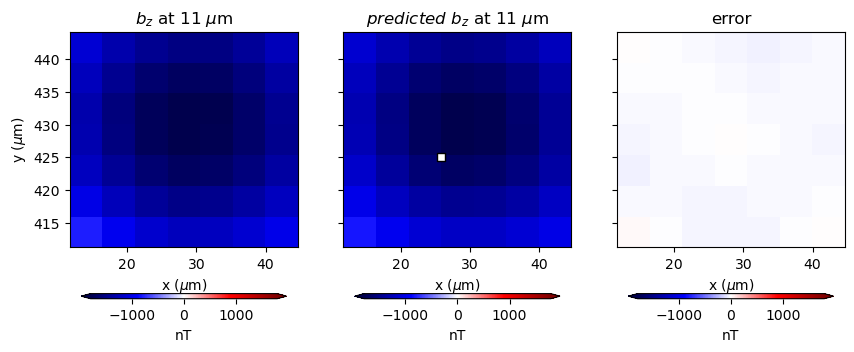

59
 R2 = 0.9883019522393887
Individual source:   R2 = 0.9846000708287099


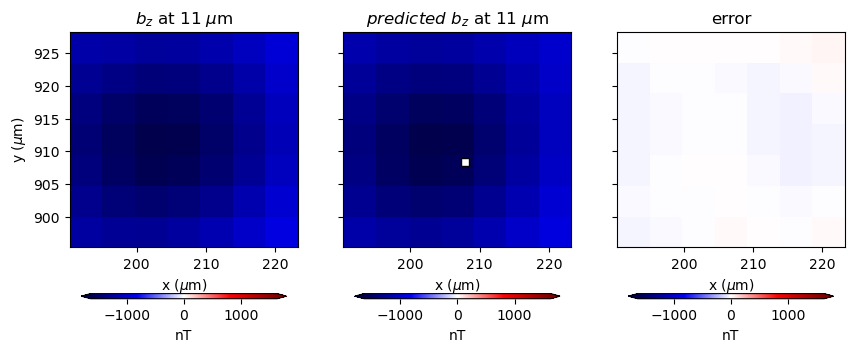

60
 R2 = 0.9932814318560192
Individual source:   R2 = 0.958857551490488


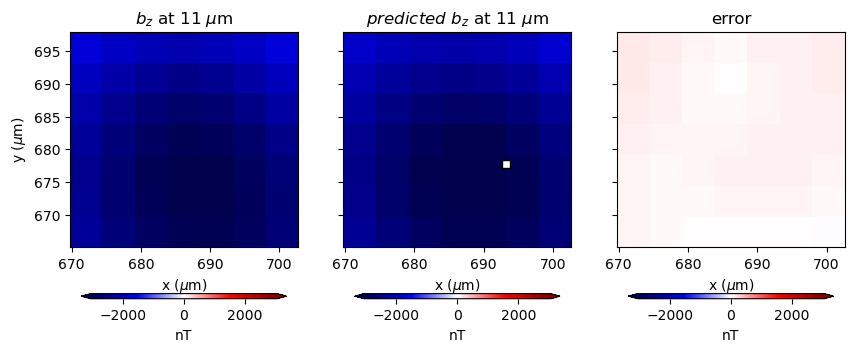

61
 R2 = 0.9691397639341859
Individual source:   R2 = 0.9683324242024163


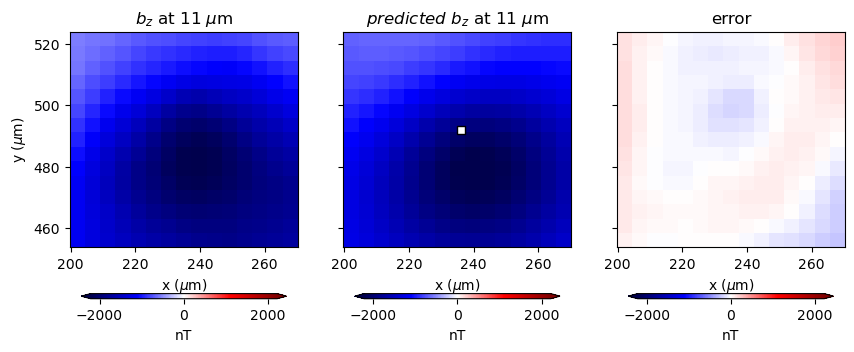

62
 R2 = 0.9984336305205969
Individual source:   R2 = 0.9986006650652843


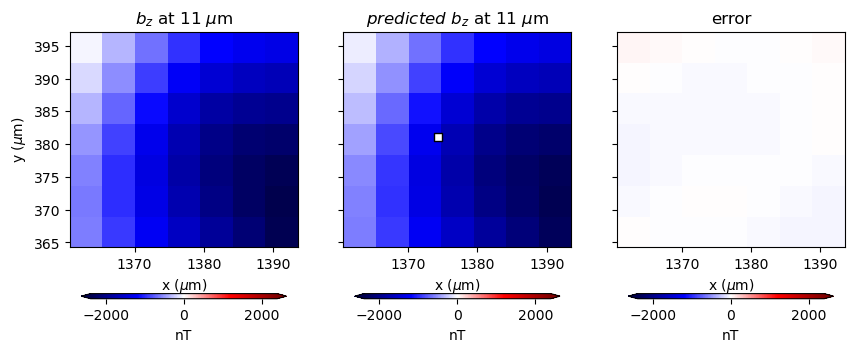

63
 R2 = 0.969980520322275
Individual source:   R2 = -0.004441171774740127


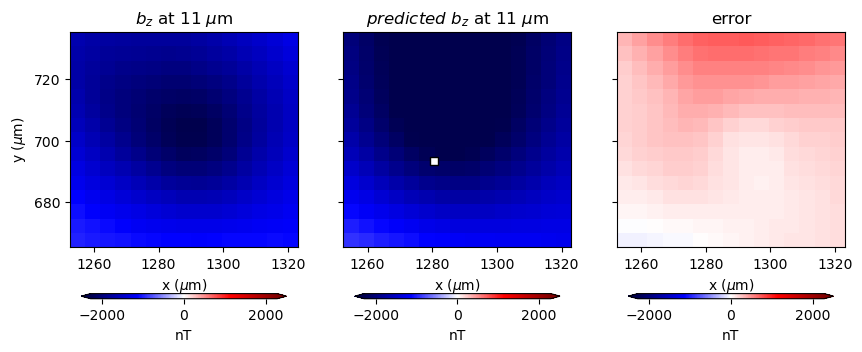

64
 R2 = 0.9895980493276326
Individual source:   R2 = 0.5833305530326887


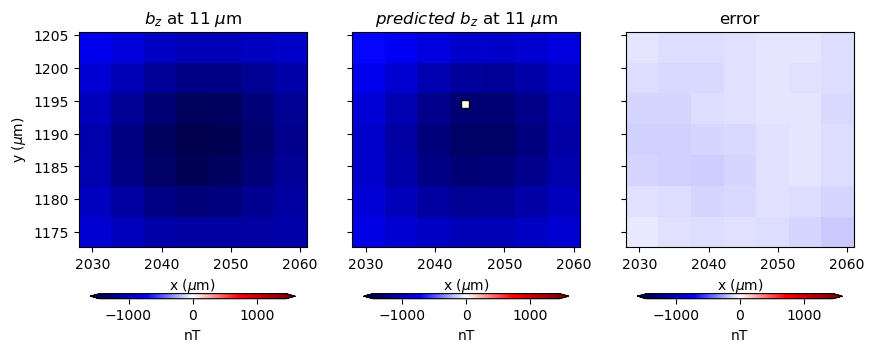

65
 R2 = 0.9707054082584117
Individual source:   R2 = -4.172420365528333


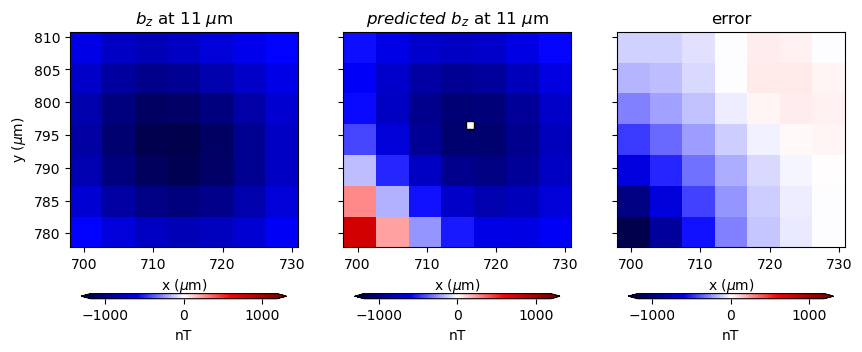

66
 R2 = 0.947851387545313
Individual source:   R2 = -0.4519949250379789


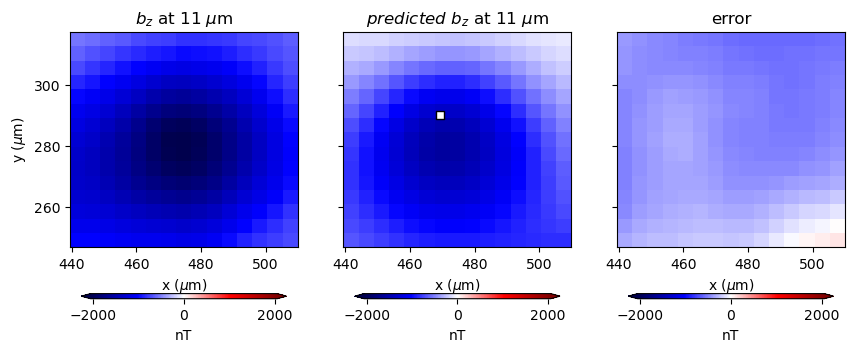

67
 R2 = 0.936778181816636
Individual source:   R2 = 0.9443135420416109


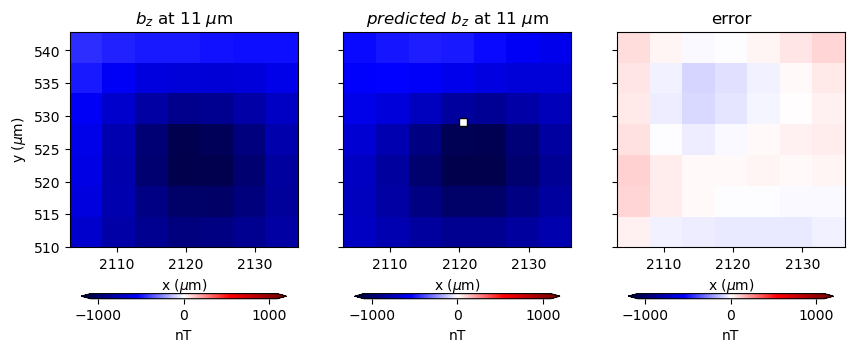

68
 R2 = 0.9950597202825733
Individual source:   R2 = 0.9912830995542323


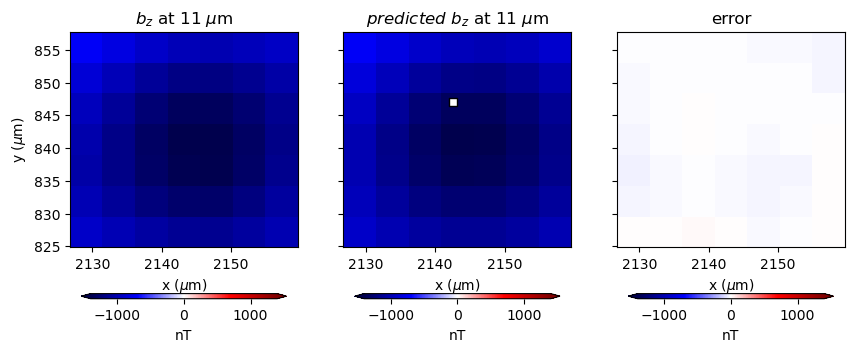

69
 R2 = 0.9783603978714925
Individual source:   R2 = 0.9000638528713049


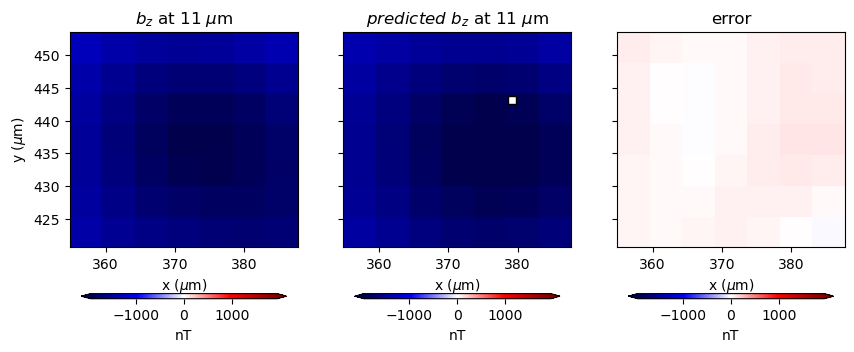

70
 R2 = 0.9525251091527732
Individual source:   R2 = 0.9544016823243355


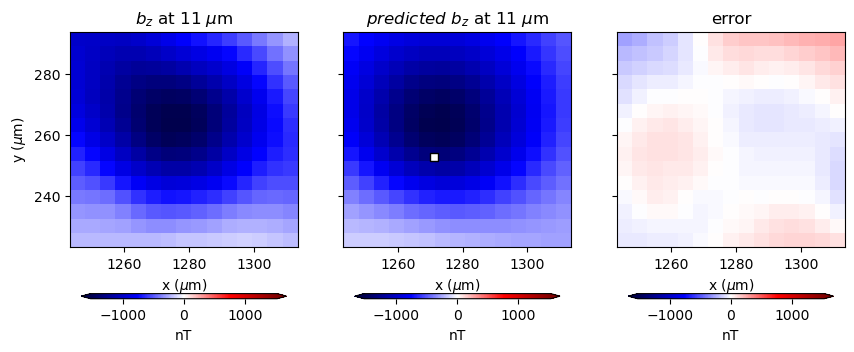

71
 R2 = 0.9349511259338712
Individual source:   R2 = 0.918989515836256


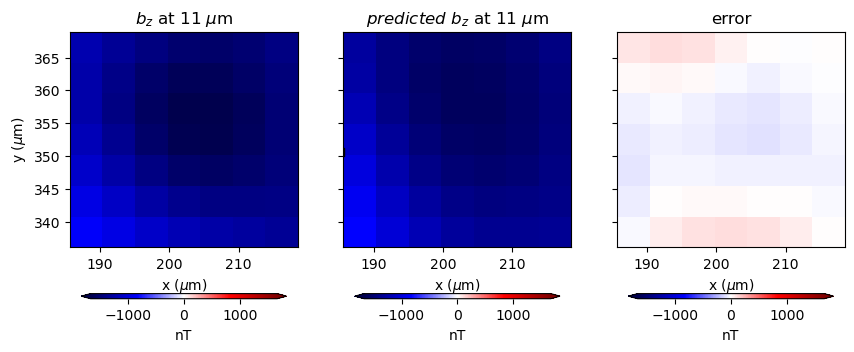

72
 R2 = 0.9698760171423539
Individual source:   R2 = 0.9657981477212642


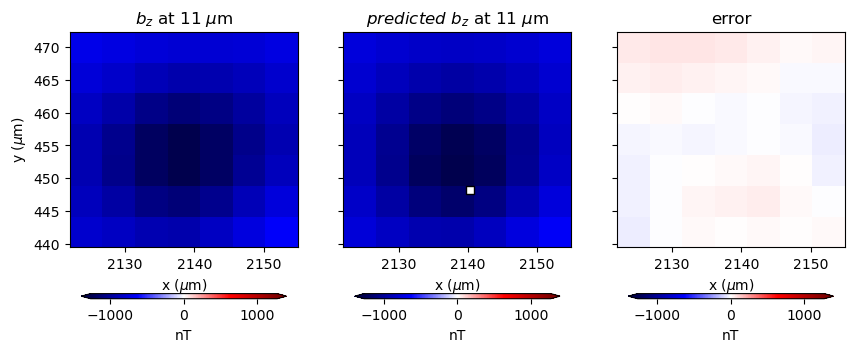

73
 R2 = 0.9385242749464436
Individual source:   R2 = -1.7355019112246497


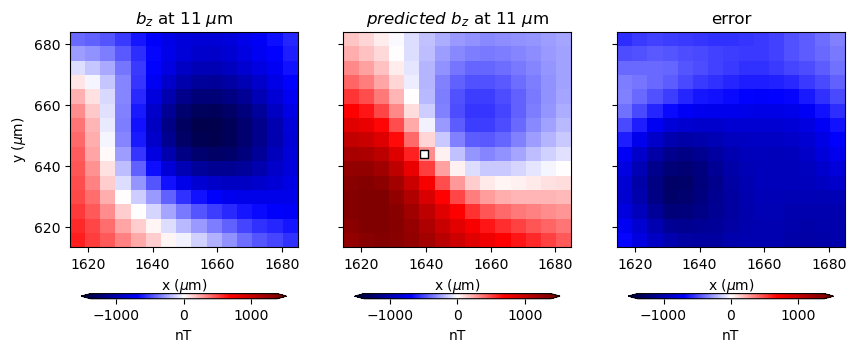

74
 R2 = 0.9965439549227559
Individual source:   R2 = -3.080566988347785


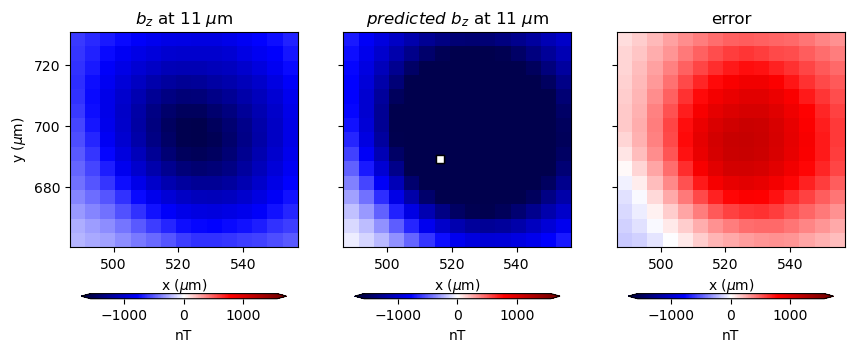

75
 R2 = 0.9965438413404802
Individual source:   R2 = -1.7327115972221168


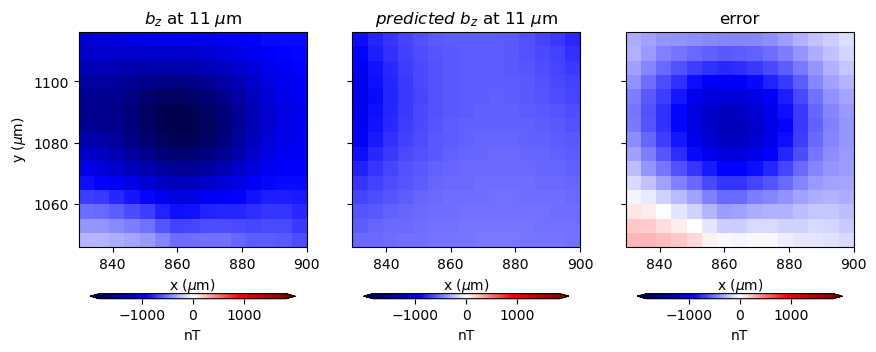

76
 R2 = 0.9763297519181575
Individual source:   R2 = 0.20975598968176223


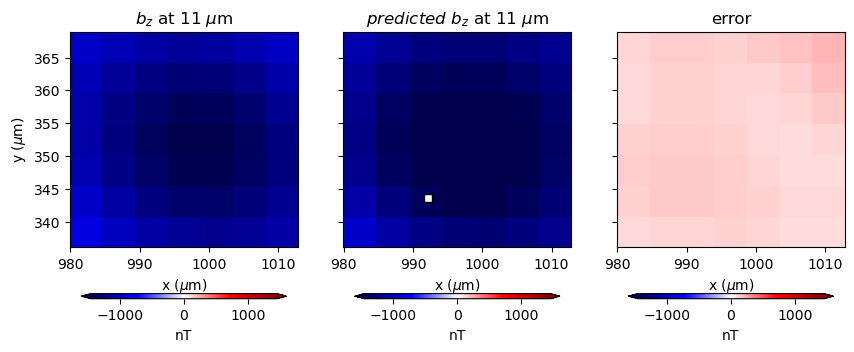

77
 R2 = 0.9764729395659163
Individual source:   R2 = 0.9760060193509416


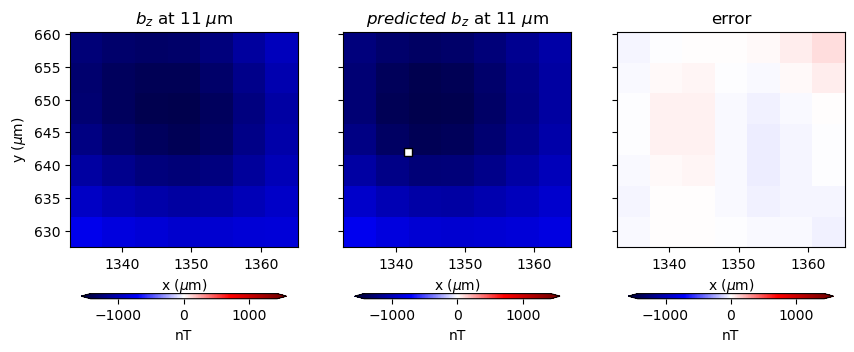

78
 R2 = 0.9866197446372087
Individual source:   R2 = -1.267487688479699


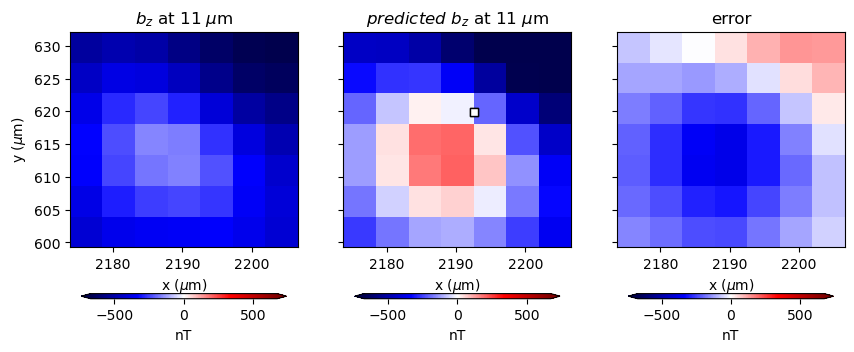

79
 R2 = 0.9891408951159685
Individual source:   R2 = -4.144579598691476


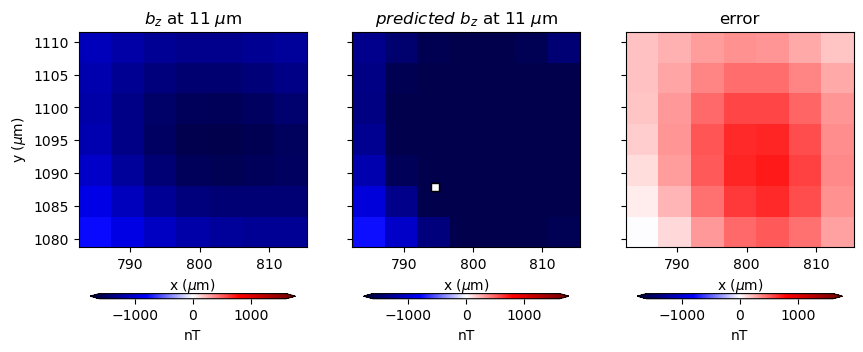

80
 R2 = 0.9866168366535054
Individual source:   R2 = -4.941723884774604


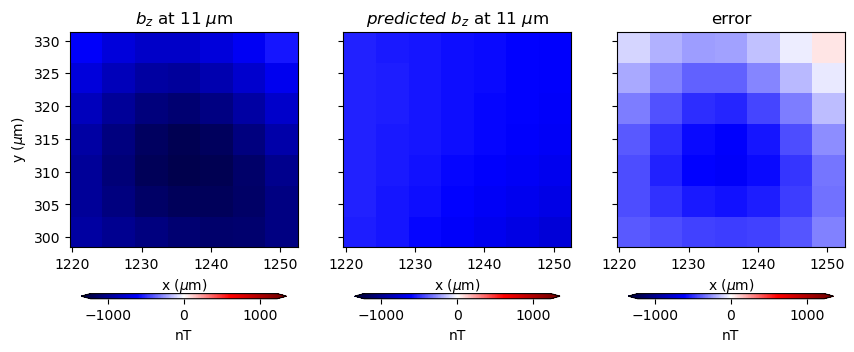

81
 R2 = 0.9891407849339999
Individual source:   R2 = -11.976435019306365


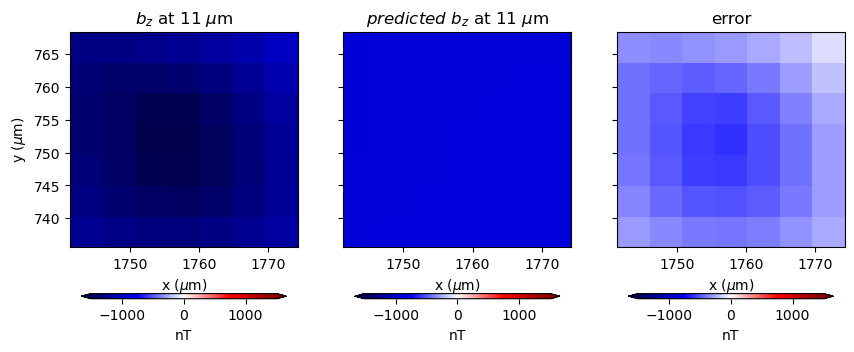

82
 R2 = 0.9912379344754099
Individual source:   R2 = -6.237093240845034


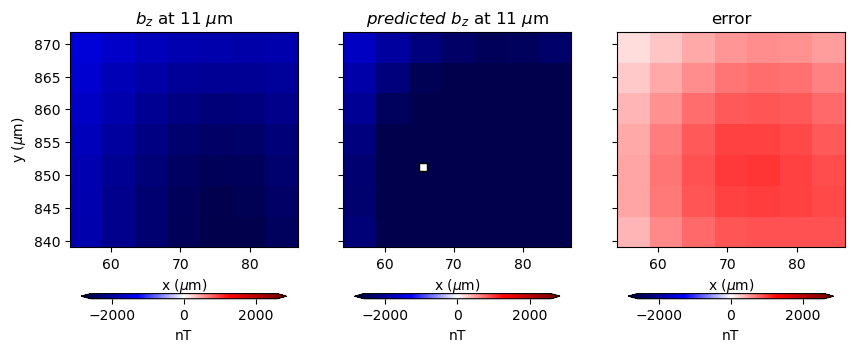

83
 R2 = 0.9843457627504624
Individual source:   R2 = -0.38079482350059757


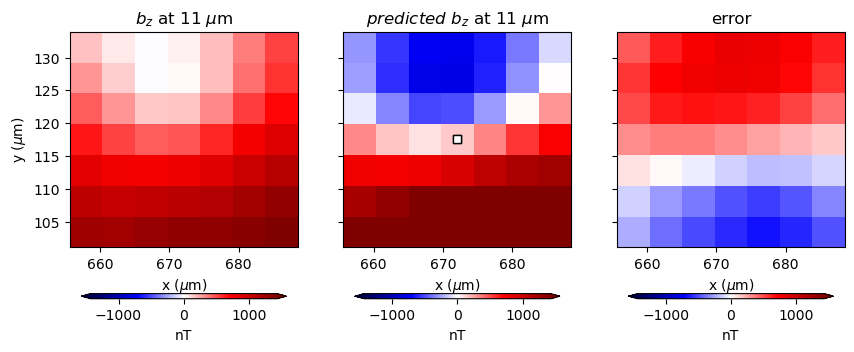

84
 R2 = 0.9048739619564826
Individual source:   R2 = -3.174638196809191


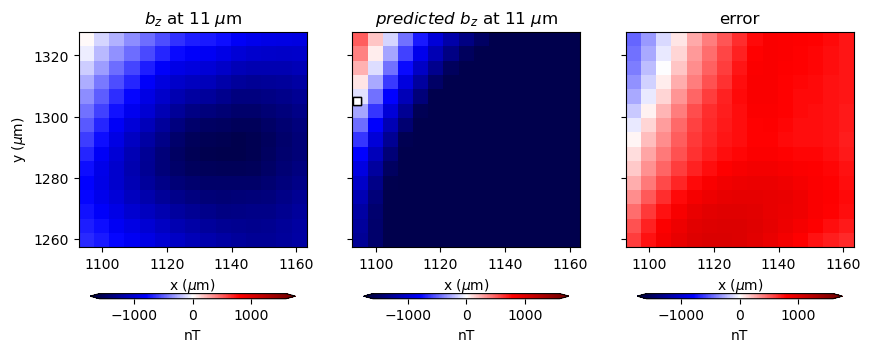

85
 R2 = 0.897261535386555
Individual source:   R2 = 0.8458285261300255


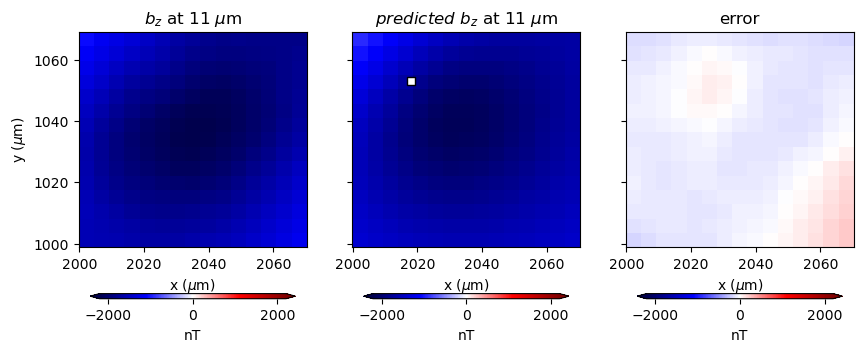

86
 R2 = 0.9813212353057974
Individual source:   R2 = -3.9139205115838918


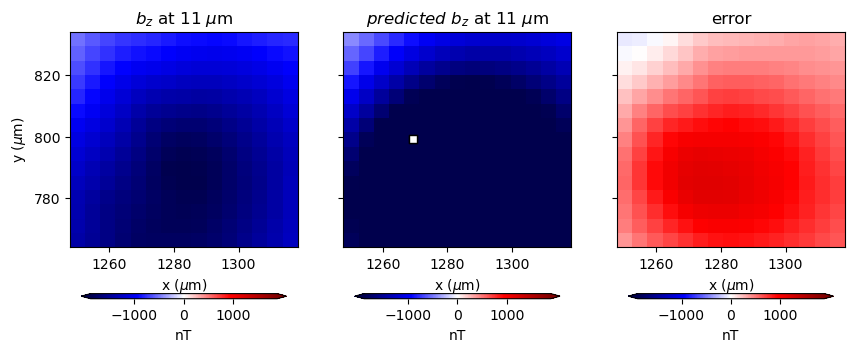

87
 R2 = 0.9912388061635765
Individual source:   R2 = 0.9811232425587976


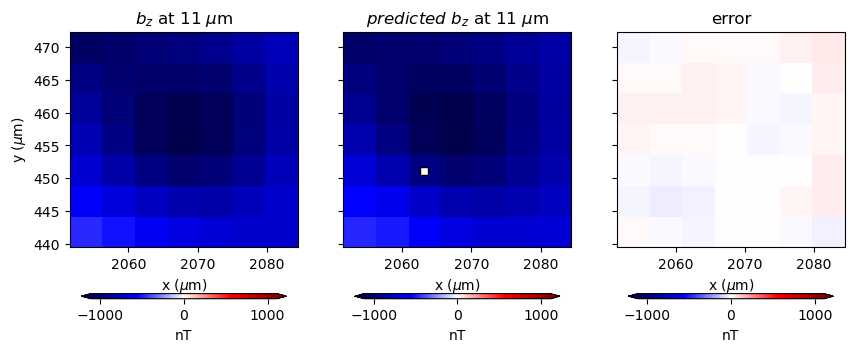

88
 R2 = 0.9843464077233466
Individual source:   R2 = -4.269604055019269


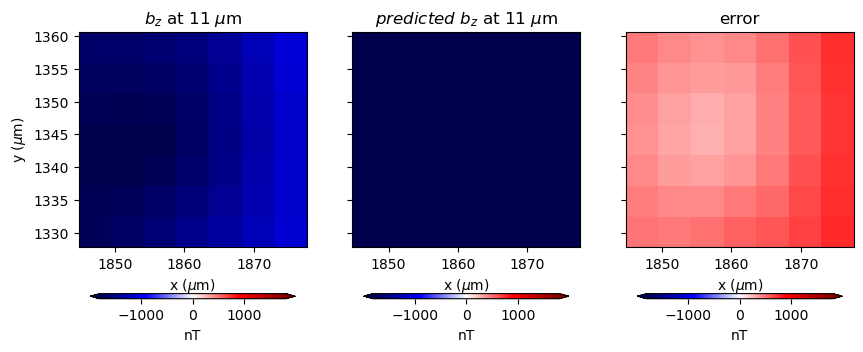

89
 R2 = 0.9378563800698766
Individual source:   R2 = 0.6951103329579789


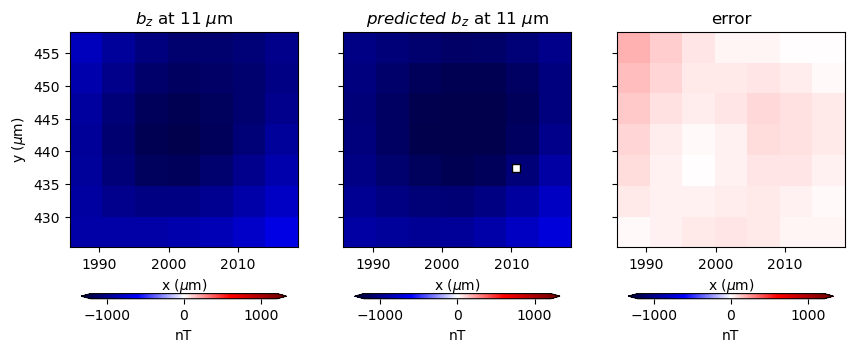

90
 R2 = 0.9050331336750231
Individual source:   R2 = 0.8005383064234783


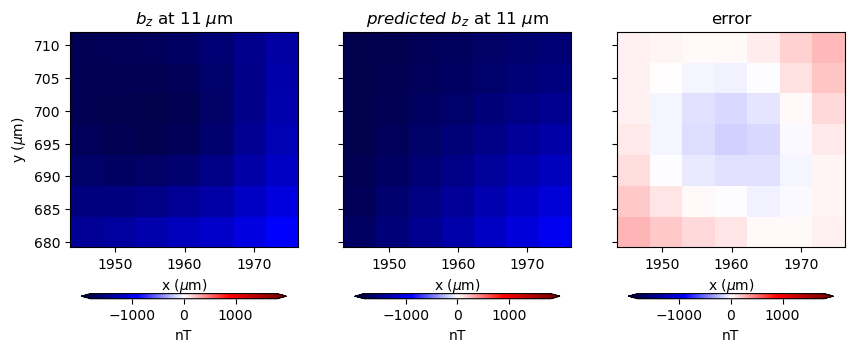

91
 R2 = 0.9310435082454003
Individual source:   R2 = 0.9207724751059598


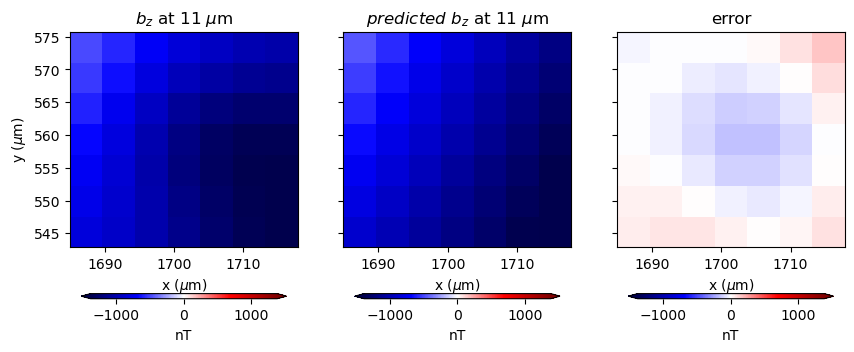

92
 R2 = 0.981314153099184
Individual source:   R2 = -5.035832838697073


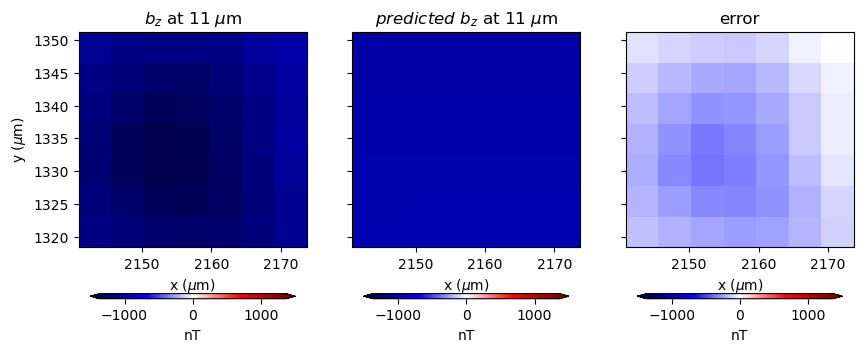

93
 R2 = 0.9802240553780561
Individual source:   R2 = 0.37019797001459265


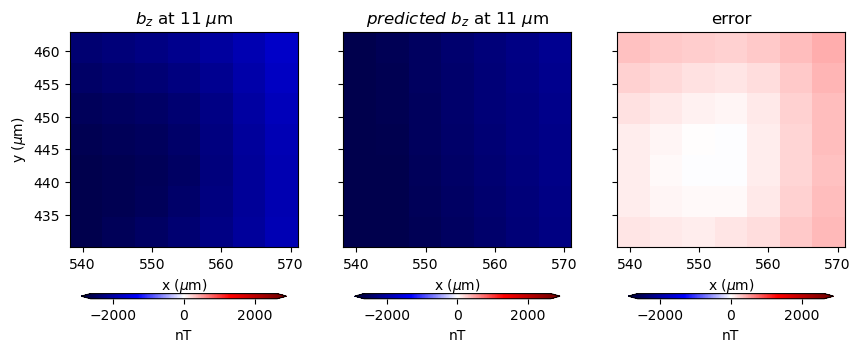

94
 R2 = 0.9770351785531776
Individual source:   R2 = 0.9727002161892103


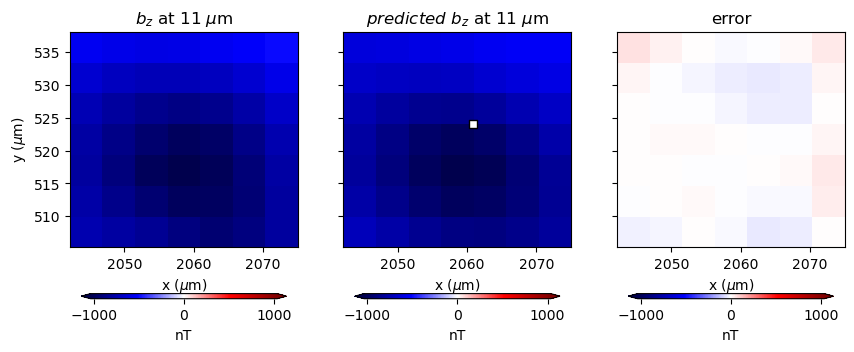

95
 R2 = 0.9955425232862883
Individual source:   R2 = -1.0596632646508781


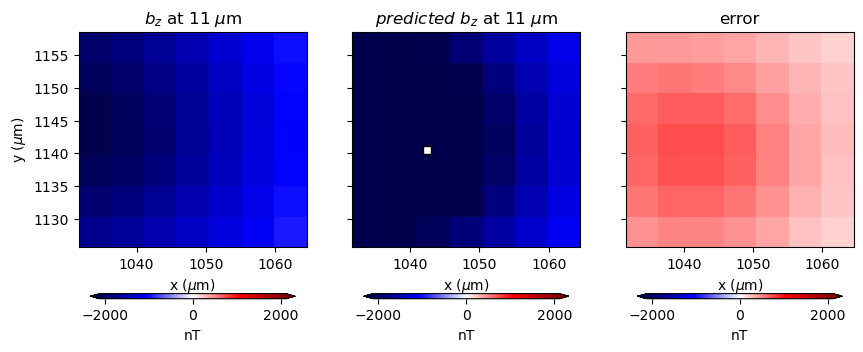

96
 R2 = 0.9862490870627457
Individual source:   R2 = -1.530428802849975


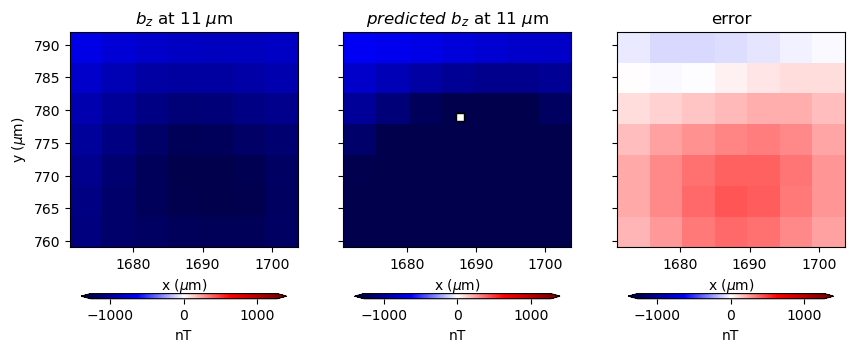

97
 R2 = 0.9804248176450611
Individual source:   R2 = 0.7246939056860418


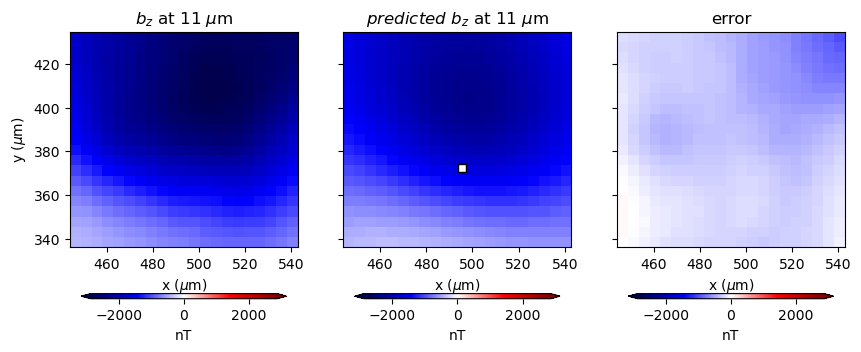

98
 R2 = 0.8591994622532204
Individual source:   R2 = -2.6860072843626557


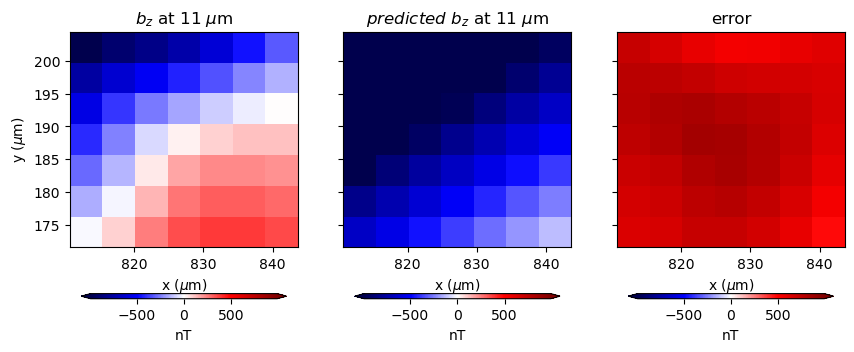

99
 R2 = 0.9833983960178622
Individual source:   R2 = -5.155913912846918


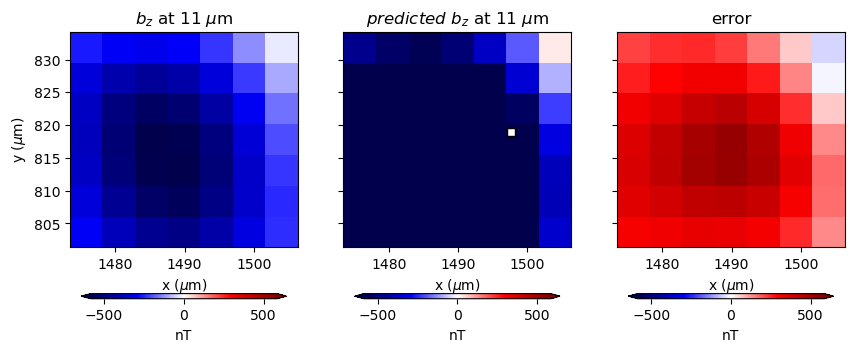

100
 R2 = 0.9955444854356708
Individual source:   R2 = 0.9010148043929008


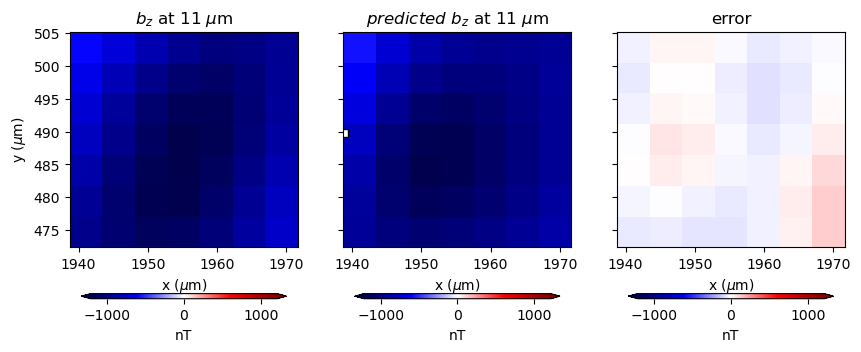

101
 R2 = 0.9687465923572269
Individual source:   R2 = 0.042378443775635044


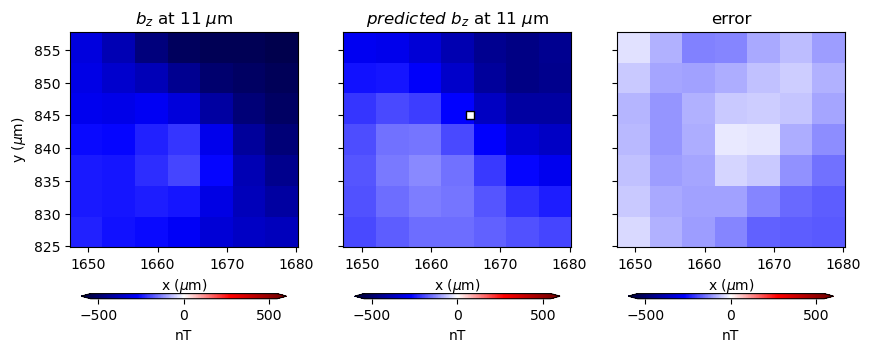

102
 R2 = 0.9862464769302662
Individual source:   R2 = -0.4470957349649909


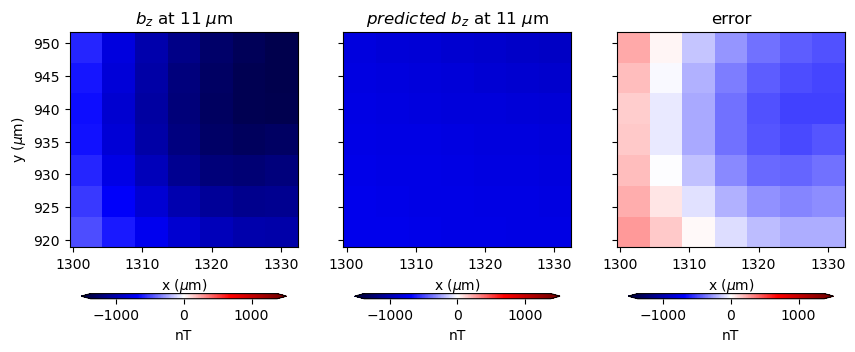

103
 R2 = 0.9865661221877905
Individual source:   R2 = 0.8593803258967966


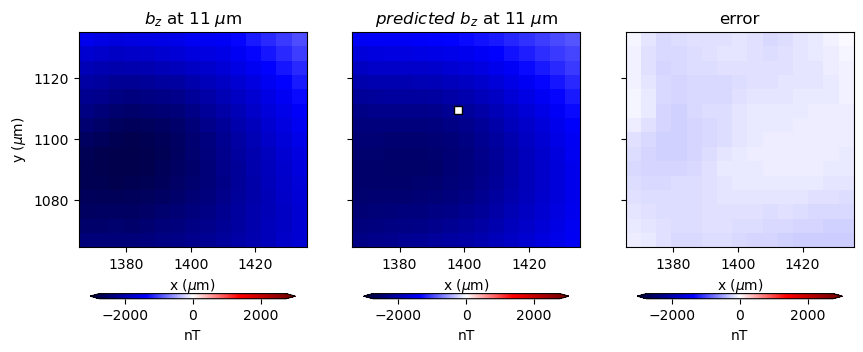

104
 R2 = 0.9649601856680379
Individual source:   R2 = 0.9676824139515194


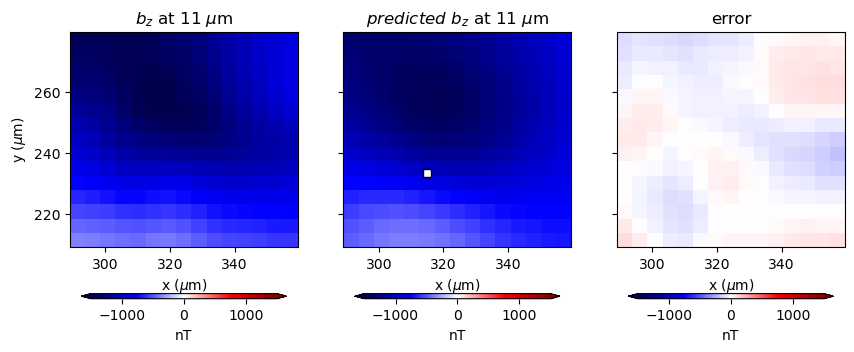

105
 R2 = 0.9833984238496273
Individual source:   R2 = -2.4096753266303934


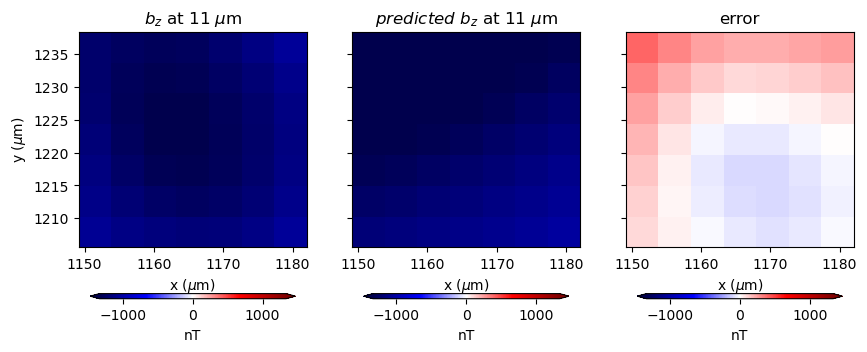

106
 R2 = 0.9950965600534534
Individual source:   R2 = 0.9941718928298433


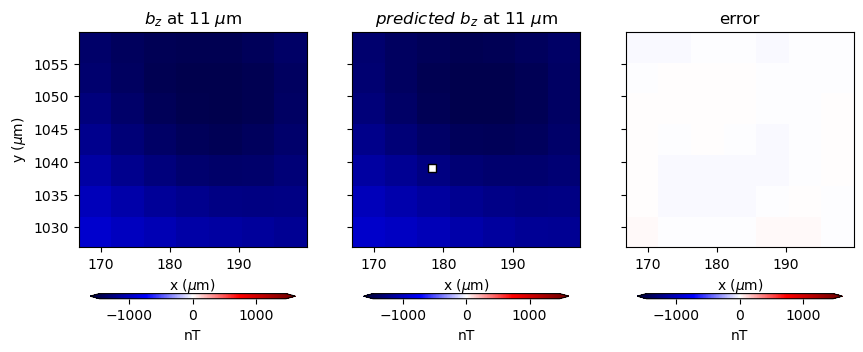

107
 R2 = 0.9036763283907472
Individual source:   R2 = -6.160034059695118


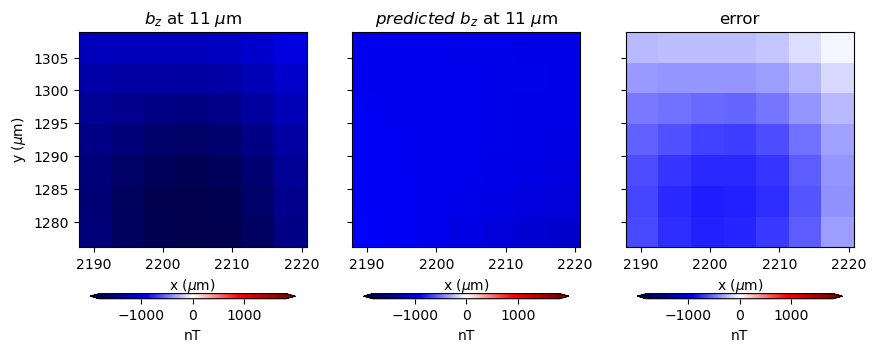

108
 R2 = 0.8791184473326292
Individual source:   R2 = 0.16725940868633182


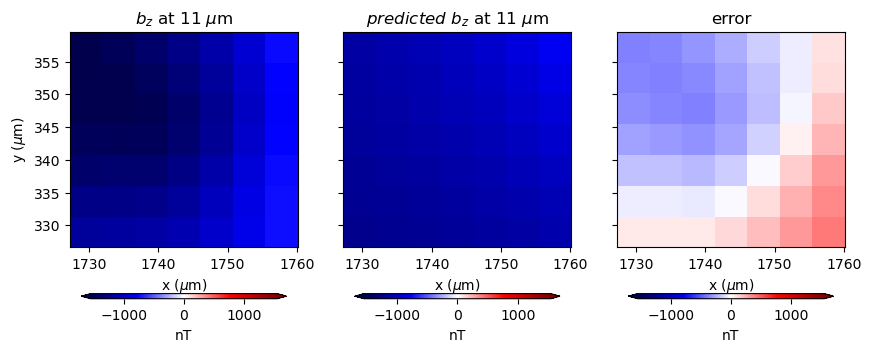

109
 R2 = 0.9202347659377663
Individual source:   R2 = -3.134127696042934


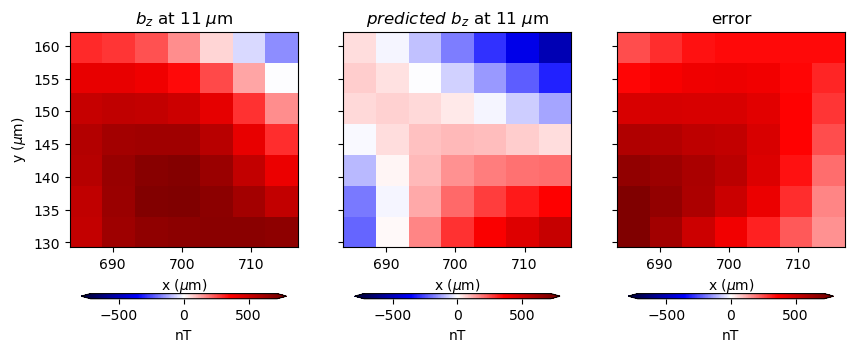

110
 R2 = 0.9899973589380642
Individual source:   R2 = 0.9847945503252767


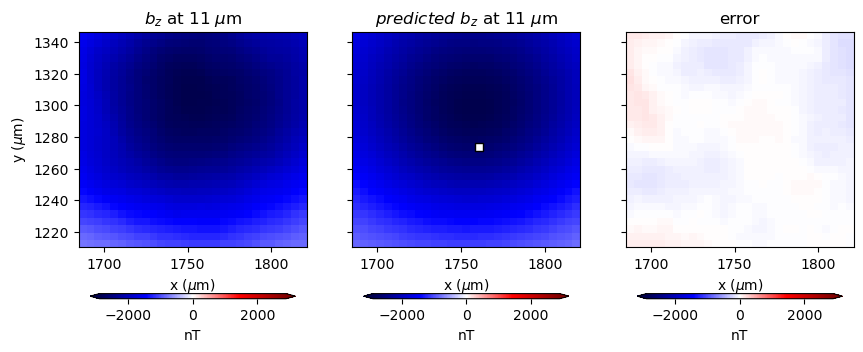

111
 R2 = 0.9754086920498232
Individual source:   R2 = -0.8710536784198277


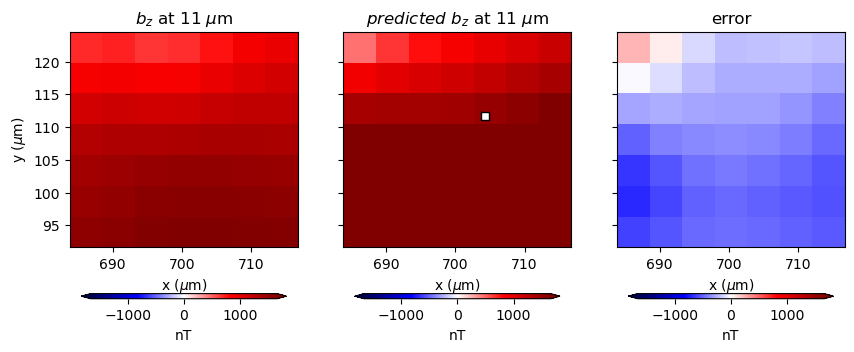

112
 R2 = 0.9810176607397698
Individual source:   R2 = 0.9844079279278136


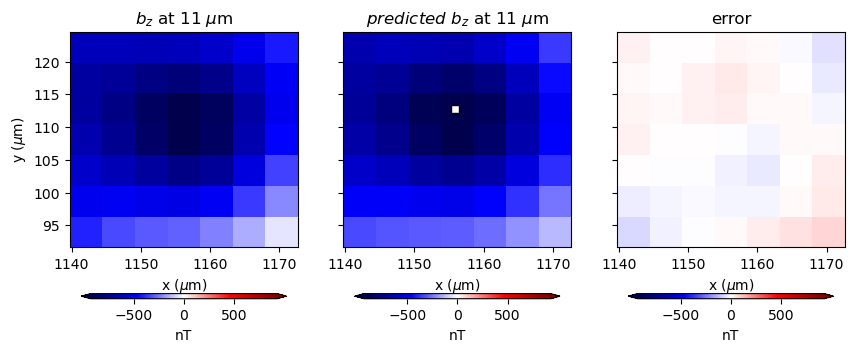

113
 R2 = 0.9677401456431112
Individual source:   R2 = 0.19238968088660624


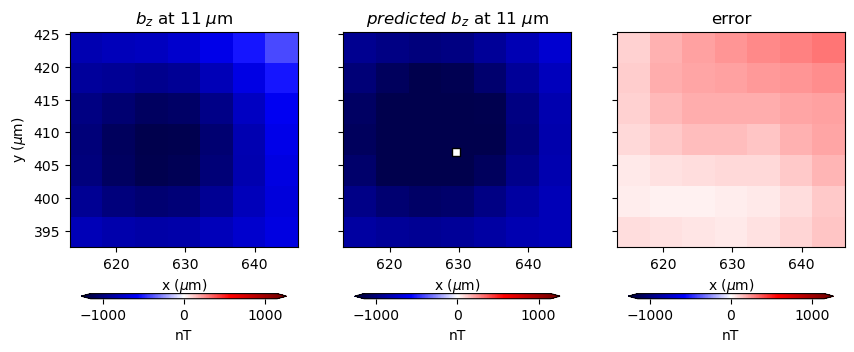

114
 R2 = 0.9842116299395792
Individual source:   R2 = -28.59529358149418


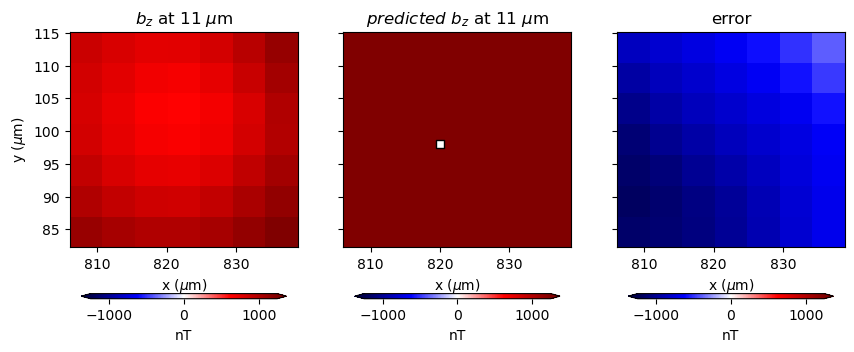

115
 R2 = 0.9112737692065251
Individual source:   R2 = 0.8365511010274962


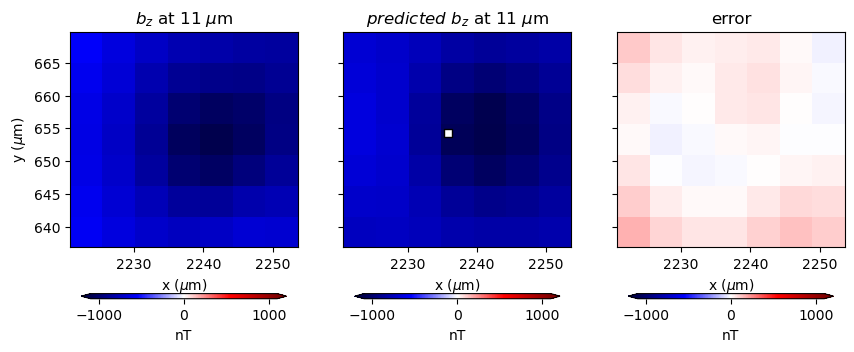

116
 R2 = 0.9302643203265903
Individual source:   R2 = 0.4264660598358212


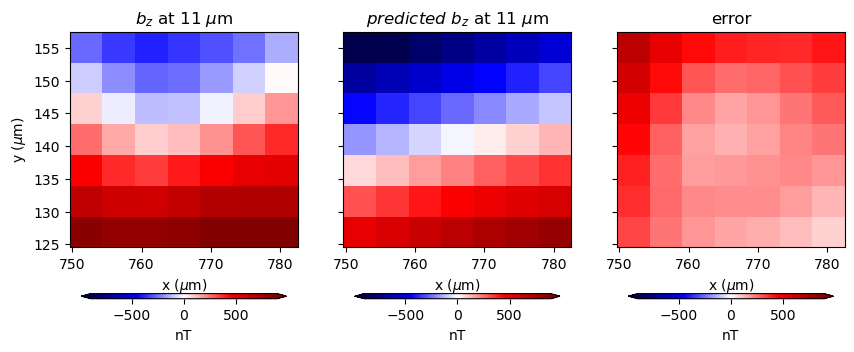

117
 R2 = 0.987382275978399
Individual source:   R2 = -69.38362874071284


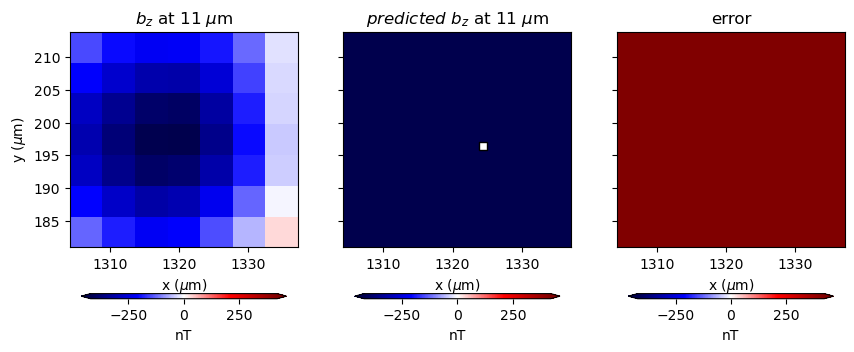

118
 R2 = 0.9740379229232093
Individual source:   R2 = -14.99305582914644


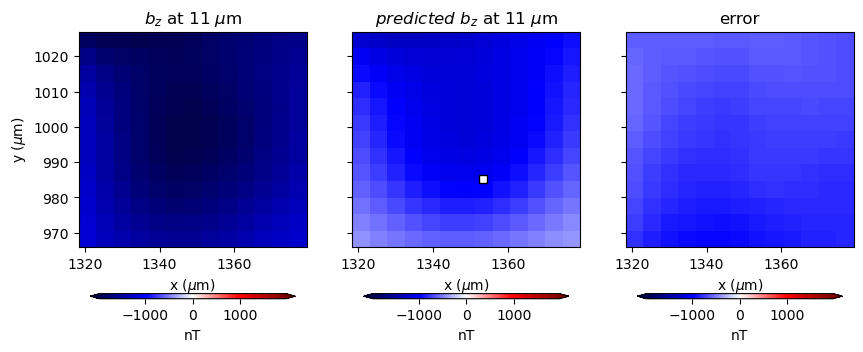

119
 R2 = 0.936873710531856
Individual source:   R2 = -3.089523723889328


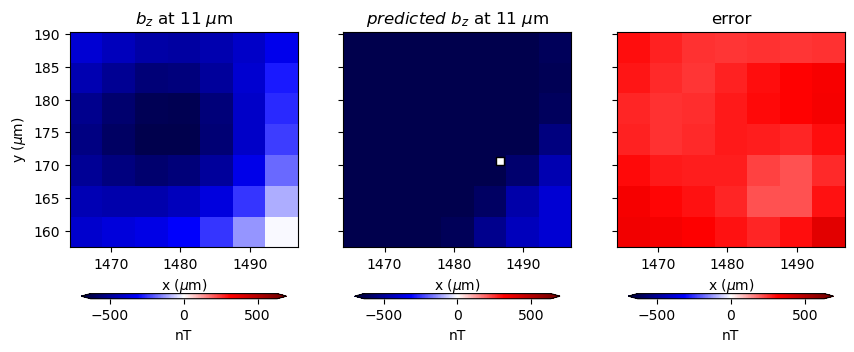

120
 R2 = 0.9763031884756593
Individual source:   R2 = -6.7871858639132885


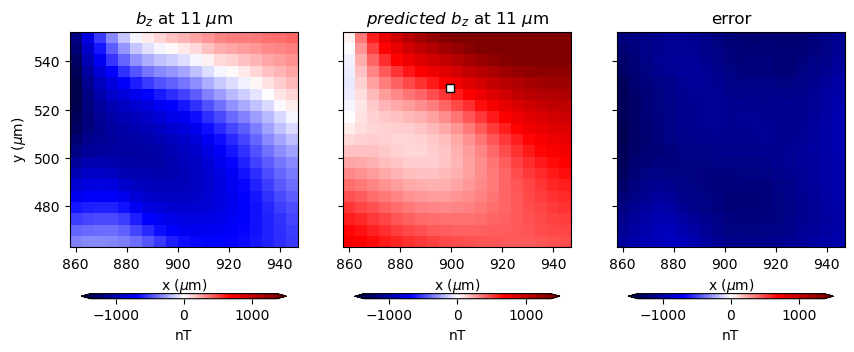

121
 R2 = 0.9739953440728836
Individual source:   R2 = -1.9925922489032541


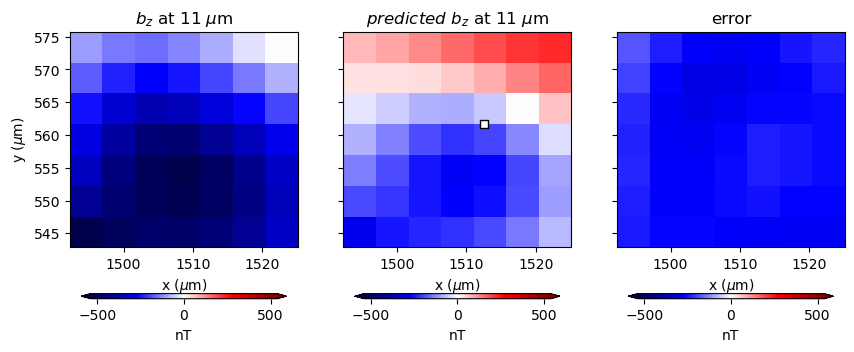

122
 R2 = 0.9754458960511454
Individual source:   R2 = 0.7950660730577264


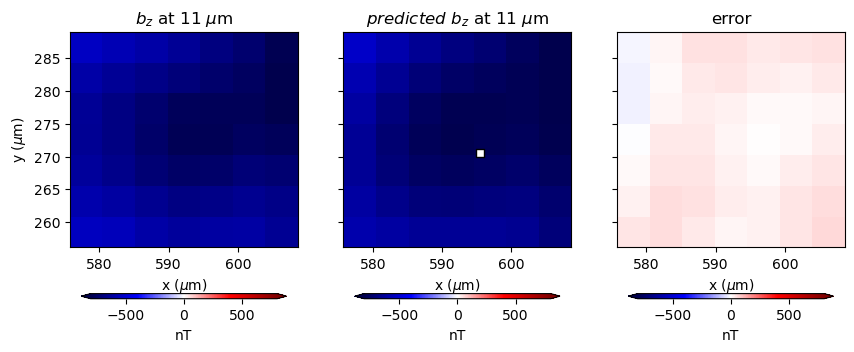

123
 R2 = 0.9639486765358208
Individual source:   R2 = -13.094806755013899


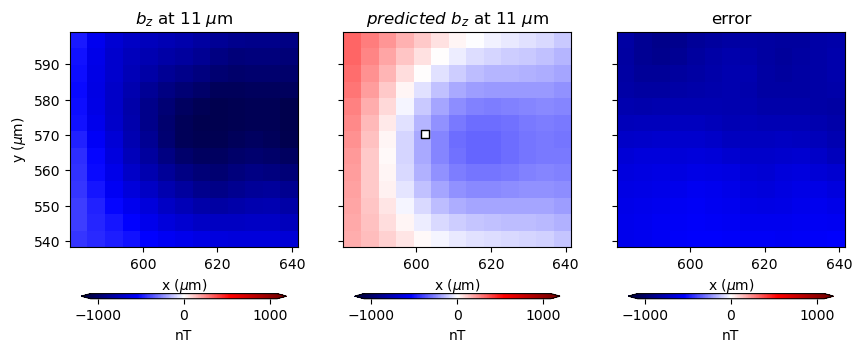

124
 R2 = 0.9040954883047971
Individual source:   R2 = 0.5924121441902158


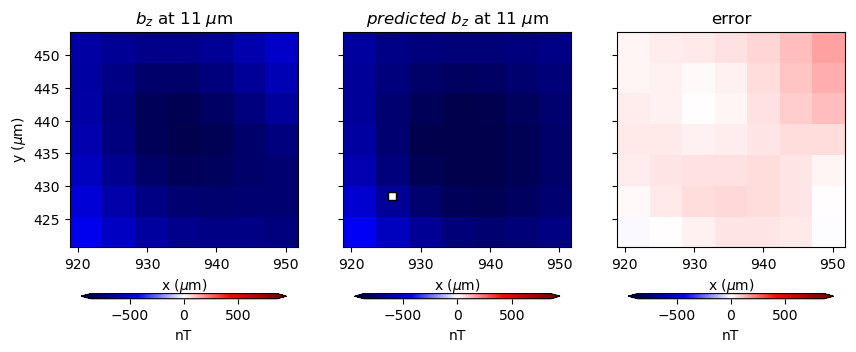

125
 R2 = 0.9681669740597191
Individual source:   R2 = -15.266568423720575


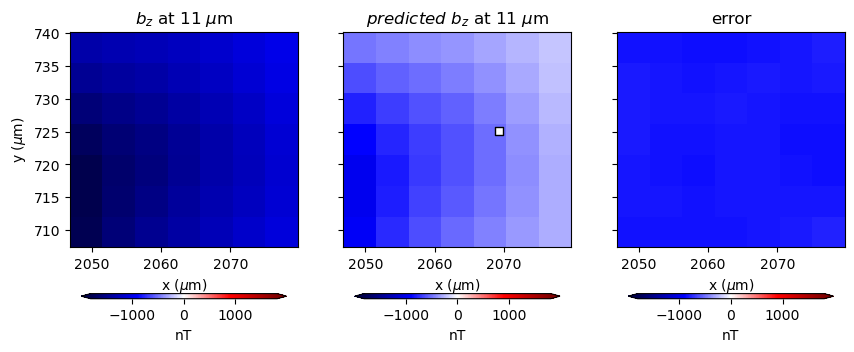

In [57]:
i = 0
for window, r2, base_level in zip(windows_enhanced[0:-1], calculated_r2_itr_euler_enhanced[0:-1], base_levels_itr_euler_enhanced[0:-1]):

    if r2>=0.85:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        vmax = np.max(abs(local_data.bz.values))
        vmin = -vmax
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values #-= base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')

        residuals = local_data.error.values
        residuals_sum_sq = np.sum(residuals**2)
        total_sum_sq = np.linalg.norm(local_data.bz.values - np.mean(local_data.bz.values))**2
        r2_ = 1 - residuals_sum_sq / total_sum_sq
    
        print(f" R2 = {r2}")
        print(f"Individual source:   R2 = {r2_}")
    
        plt.show()

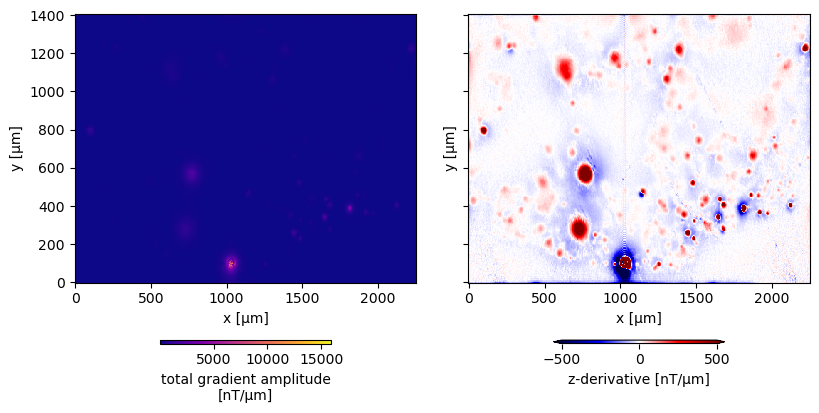

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmin = None
        vmax = None
    else:
        cmap="seismic"
        vmin = -500
        vmax = 500
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)
for ax in axes.ravel():
    ax.set_aspect("auto")

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

# Export Windows and Results

In [59]:
# Criando o DataFrame
df_windows = pd.DataFrame(
        {
            'index': np.arange(len(windows_enhanced)),
            'x_min': np.asarray(windows_enhanced)[:, 0],
            'x_max': np.asarray(windows_enhanced)[:, 1],
            'y_min': np.asarray(windows_enhanced)[:, 2],
            'y_max': np.asarray(windows_enhanced)[:, 3]
        })


In [75]:
df_windows.head(2)

index        r2           xc          yc         zc            mx  \
0      0  0.997151   772.636077  568.432660 -60.172413  1.215915e-11   
1      1  0.998162  1812.626390  386.288434 -11.881541 -6.314433e-13   

             my            mz  
0  1.849481e-12 -8.355812e-11  
1 -3.027035e-13 -1.966720e-12

In [81]:
df_reults = pd.DataFrame(
        {
'index': np.arange(len(windows_enhanced)),
'r2': calculated_r2_itr_euler_enhanced,
'xc': np.asarray(positions_itr_enhanced)[0, :],
'yc': np.asarray(positions_itr_enhanced)[1, :],
'zc': np.asarray(positions_itr_enhanced)[2, :],
'mx': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
'my': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
'mz': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
'inc':np.asarray(mg.vector_to_angles(estimated_dipole_moments_itr_euler_enhanced))[0,:],
'dec':np.asarray(mg.vector_to_angles(estimated_dipole_moments_itr_euler_enhanced))[1,:],            
'm':np.asarray(mg.vector_to_angles(estimated_dipole_moments_itr_euler_enhanced))[2,:],        
                 

            
        })

In [82]:
df_reults.head(2)

index        r2           xc          yc         zc            mx  \
0      0  0.997151   772.636077  568.432660 -60.172413  1.215915e-11   
1      1  0.998162  1812.626390  386.288434 -11.881541 -6.314433e-13   

             my            mz        inc         dec             m  
0  1.849481e-12 -8.355812e-11  81.626698   81.351260  8.445842e-11  
1 -3.027035e-13 -1.966720e-12  70.401748 -115.612294  2.087664e-12

In [87]:
df_reults.to_csv(data_dir/sample_name, index=False)

TypeError: tuple indices must be integers or slices, not tuple